In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm
import lightgbm as lgbm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## 【問題1】クロスバリデーション
事前学習期間では検証用データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。
事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。


In [3]:
train = pd.read_csv('../week3/application_train.csv')
test = pd.read_csv('../week3/application_test.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 92.38 Mb (67.7% reduction)
Mem. usage decreased to 14.60 Mb (67.6% reduction)


In [5]:
idx = train.loc[train['DAYS_EMPLOYED']!=365243, :].index
mean = train[train['DAYS_EMPLOYED']!=365243]['DAYS_EMPLOYED'].mean()
train.loc[idx, 'DAYS_EMPLOYED'] = mean
test.loc[test['DAYS_EMPLOYED']==365243, 'DAYS_EMPLOYED'] = mean

### ベースモデル

In [6]:
X = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].values
y = train['TARGET'].values

In [7]:
kf = KFold(n_splits=2, shuffle=True)
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lgb_train = lgbm.Dataset(X_train, y_train)
    lgb = lgbm.train(params, lgb_train)
    y_pred = lgb.predict(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    print('AUC: {:.4f}'.format(metrics.auc(fpr, tpr)))

AUC: 0.7201
AUC: 0.7207


## 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。
scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

In [8]:
params = {
    'objective': 'regression', # for regression
    'boosting_type': 'dart',
    'num_iterations': 100,  # default
    'learning_rate': 0.01,
    'num_leaves': 31,  # default
    'device_type': 'cpu',
    'max_depth': -1, # <0 means no limit, default -1
    'max_bin': 255, # default 255, Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # default 0.0, L1 regularization
    'lambda_l2': 10, # default 0.0, L2 regularization
    'metric' : 'auc',
    'bin_construct_sample_cnt': 200, # default 200000, number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1e-3, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

model = lgbm.LGBMRegressor(boosting_type='dart',
                          objective='regression',
                          n_jobs=5,
                          silent=False,
                          max_depth=params['max_bin'],
                          subsample_for_bin=params['bin_construct_sample_cnt'],
                          subsample=params['subsample'],
                          min_split_gain=params['min_split_gain'],
                          min_child_weight=params['min_child_weight'],
                          min_child_samples=params['min_child_samples']
                         )

model.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [9]:
def auc(y_test, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    return metrics.auc(fpr, tpr)

In [10]:
gridParams = {
    'learning_rate': [0.01, 0.05],
    'n_estimators': [64, 128],
    'num_leaves': [12, 16],
    'boosting_type': ['dart'],
    'objective': ['regression',],
    'max_bin': [128, 256],
    'ramdom_state': [0,],
    'colsample_bytree': [0.64, 0.66],
    'subsample': [0.5, 0.7],
    'reg_alpha': [0.8, 1],
    'reg_lambda': [1,],
    'metric': ['auc',]
}

my_auc = metrics.make_scorer(auc)
grid = GridSearchCV(model, gridParams, verbose=1, cv=4, n_jobs=-1, scoring=my_auc)
grid.fit(X, y)

Fitting 4 folds for each of 128 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed: 27.5min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='dart', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=255, min_child_samples=5,
                                     min_child_weight=0.001, min_split_gain=0.5,
                                     n_estimators=100, n_jobs=5, num_leaves=31,
                                     objective='regression', random_state=None,
                                     reg_alpha=0.0, reg...
             param_grid={'boosting_type': ['dart'],
                         'colsample_bytree': [0.64, 0.66],
                         'learning_rate': [0.01, 0.05], 'max_bin': [128, 256],
                         'metric': ['auc'], 'n_estimators': [64, 128],
                         'num_leaves': [12, 16], 'objective': ['regression'],
                  

In [11]:
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'dart', 'colsample_bytree': 0.64, 'learning_rate': 0.05, 'max_bin': 256, 'metric': 'auc', 'n_estimators': 128, 'num_leaves': 16, 'objective': 'regression', 'ramdom_state': 0, 'reg_alpha': 0.8, 'reg_lambda': 1, 'subsample': 0.5}
0.7224875640957057


In [12]:
params = {'boosting_type': 'dart',
          'colsample_bytree': 0.64,
          'learning_rate': 0.05,
          'max_bin': 255,
          'metric': 'auc',
          'n_estimators': 24,
          'num_leaves': 16,
          'objective': 'regression',
          'ramdom_state': 0,
          'reg_alpha': 0.8, 
          'reg_lambda': 1, 
          'subsample': 0.5,
         }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
d_train = lgbm.Dataset(X_train, label=y_train)
d_valid = lgbm.Dataset(X_test, label=y_test)

watchlist = [d_train, d_valid]

model = lgbm.train(params, train_set=d_train, num_boost_round=1000,
                   valid_sets=watchlist, early_stopping_rounds=50, verbose_eval=4)

y_pred = model.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr, tpr))

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[4]	training's auc: 0.714936	valid_1's auc: 0.720187
[8]	training's auc: 0.716617	valid_1's auc: 0.720891
[12]	training's auc: 0.721271	valid_1's auc: 0.726118
[16]	training's auc: 0.721146	valid_1's auc: 0.725638
[20]	training's auc: 0.721807	valid_1's auc: 0.72648
[24]	training's auc: 0.722368	valid_1's auc: 0.727084
0.7270837866613147


## 【問題3】Kernelからの調査
KaggleのKernelから様々なアイデアを見つけ出して、列挙してください。

- PolynomialFeatrueを作成  
- Null importanceで特徴量の重要度を評価する
- Permutation importanceで特徴量の重要度を評価する

## 【問題4】
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。
その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。

### Null importanceの評価

In [13]:
def HoldoutTS(train, features, target, test=None):
    categorical_feats = train[features].columns[train[features].dtypes=='object']
    train[categorical_feats] = train[categorical_feats].fillna(value='None')
    
    for c in categorical_feats:
        data_tmp = pd.DataFrame({c: train[c], 'target': train[target]})
        target_mean = data_tmp.groupby(c)['target'].mean()
        if test is not None:
            test[c] = test[c].map(target_mean)
        tmp = np.repeat(np.nan, train.shape[0])
        kf = KFold(n_splits=4, shuffle=True)
        for idx_1, idx_2 in kf.split(train):
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            tmp[idx_2] = train[c].iloc[idx_2].map(target_mean)
        train[c] = tmp

In [14]:
def get_feature_importances(data, features, target, shuffle=False, random_seed=None):
    
    X = data[features]
    y = data[target].copy()
    
    if shuffle:
        y = np.random.permutation(y)
    
    dtrain = lgbm.Dataset(X, y, free_raw_data=False, silent=True)
    params = {
        'objective': 'regression',
        'boosting_type': 'dart',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 8,
        'seed': random_seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    clf = lgbm.train(params=params, 
                     train_set=dtrain, 
                     num_boost_round=200,
                     #categorical_feature=name:categorical_feats
    )
    
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = auc(y, clf.predict(data[features]))
    
    return imp_df

In [16]:
features = train.drop(columns=['TARGET'], axis=1).columns
HoldoutTS(train, features, 'TARGET', test=test)
actual_imp_df = get_feature_importances(train, features, 'TARGET')
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,SK_ID_CURR,0.00000,0,0.753386
1,NAME_CONTRACT_TYPE,35.11602,9,0.753386
2,CODE_GENDER,257.46638,40,0.753386
3,FLAG_OWN_CAR,37.11933,8,0.753386
4,FLAG_OWN_REALTY,3.11894,1,0.753386


In [17]:
null_imp_df = pd.DataFrame()
nb_runs = 64

for i in tqdm(range(nb_runs)):
    imp_df = get_feature_importances(train, features, 'TARGET', shuffle=True)
    imp_df['run'] = i + 1
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)

In [18]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = GridSpec(1, 2)
    
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature']==feature_, 'importance_split'].values,
                label='Null_importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature']==feature_, 'importance_split'].mean(),
              ymin=0, ymax=np.max(a[0]), color='r', linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title(f'Split Importance of {feature_.upper()}', fontweight='bold')
    plt.xlabel(f'Null Importance (split) Distribution for {feature_.upper()}')
    
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature']==feature_, 'importance_gain'].values,
                label='Null_importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature']==feature_, 'importance_gain'].mean(),
              ymin=0, ymax=np.max(a[0]), color='r', linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title(f'Gain Importance of {feature_.upper()}', fontweight='bold')
    plt.xlabel(f'Null Importance (gain) Distribution for {feature_.upper()}')
    

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


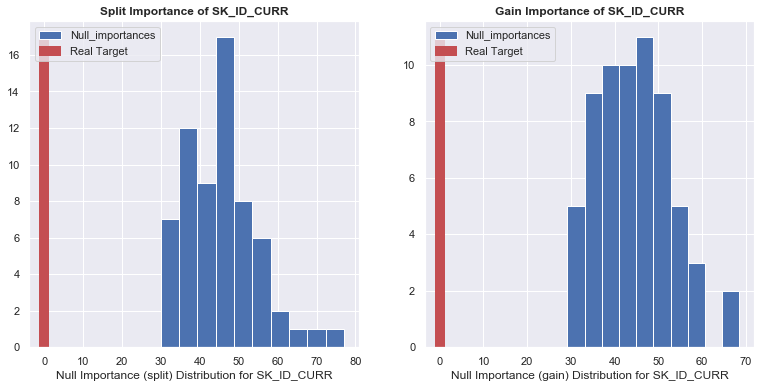

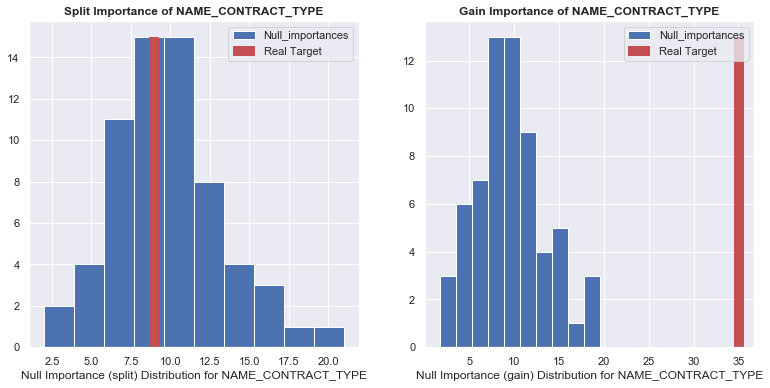

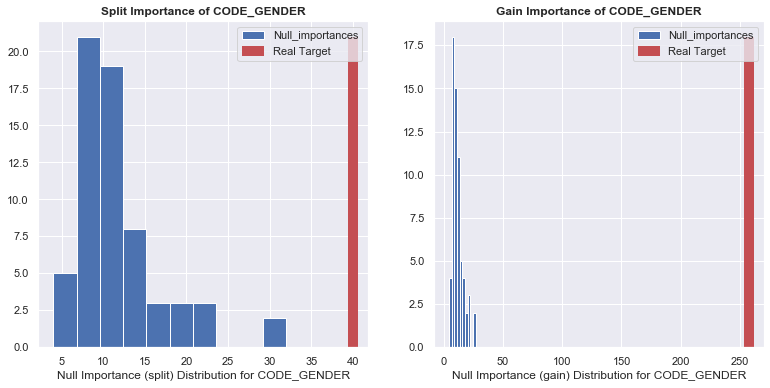

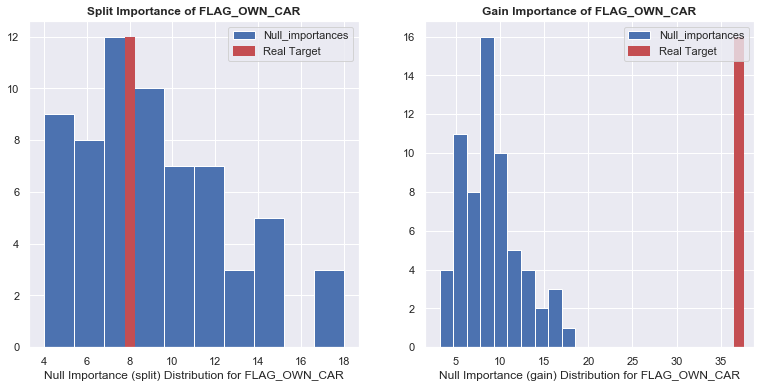

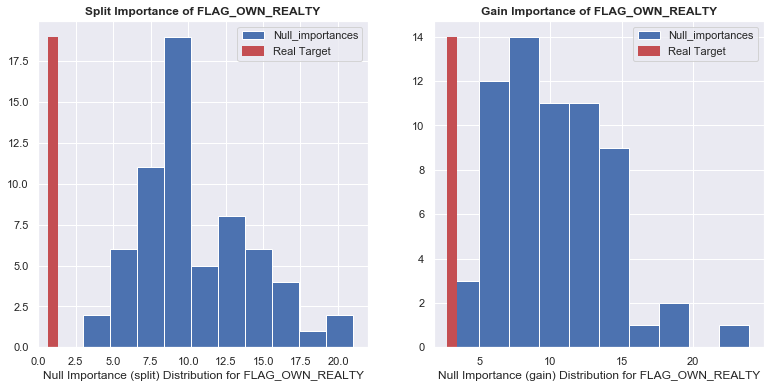

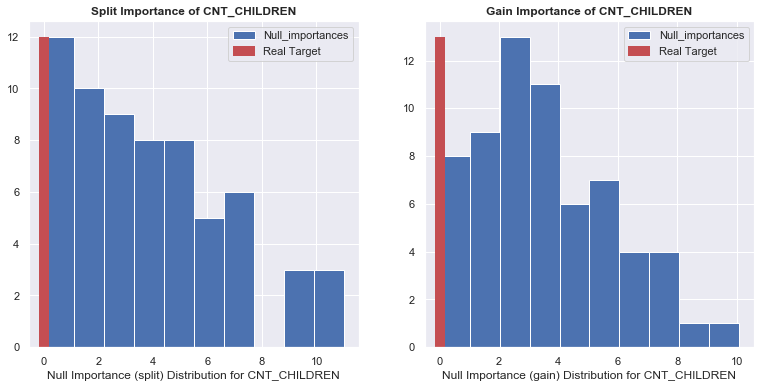

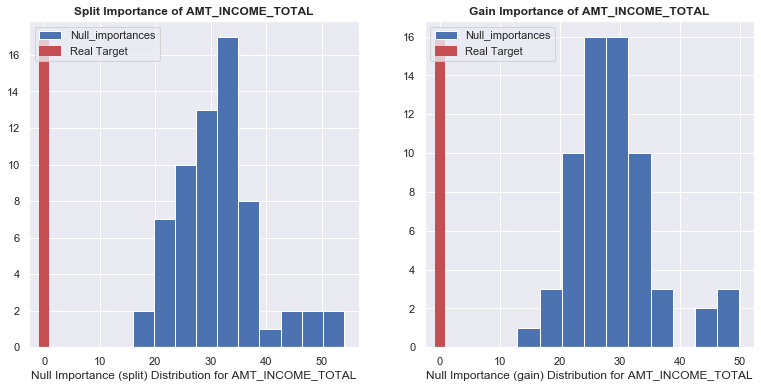

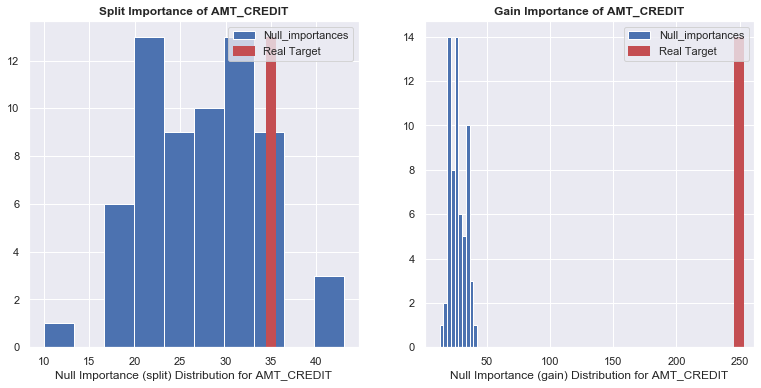

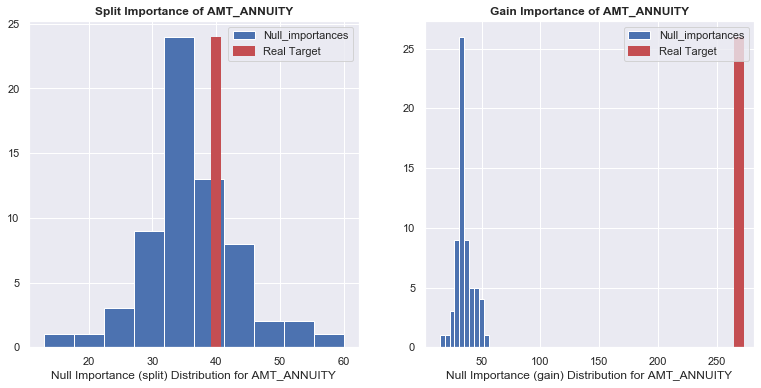

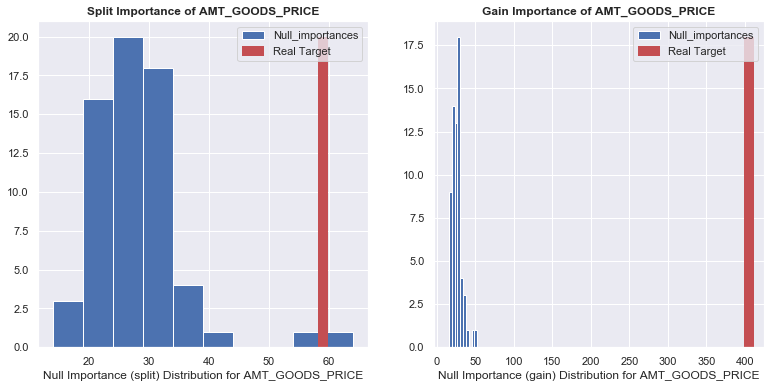

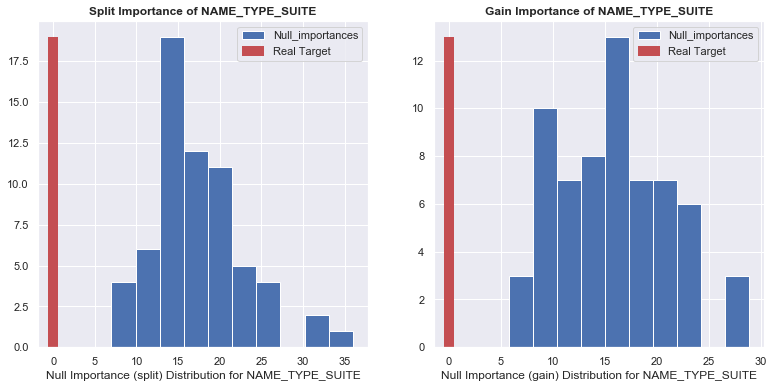

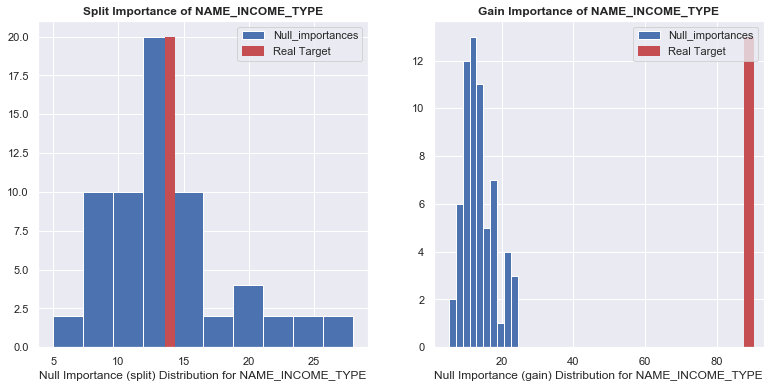

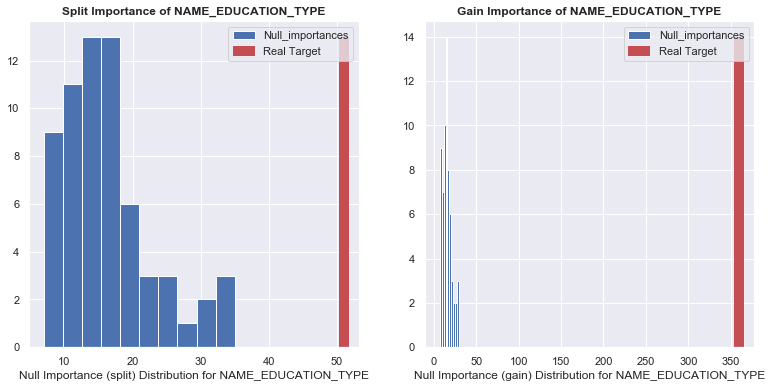

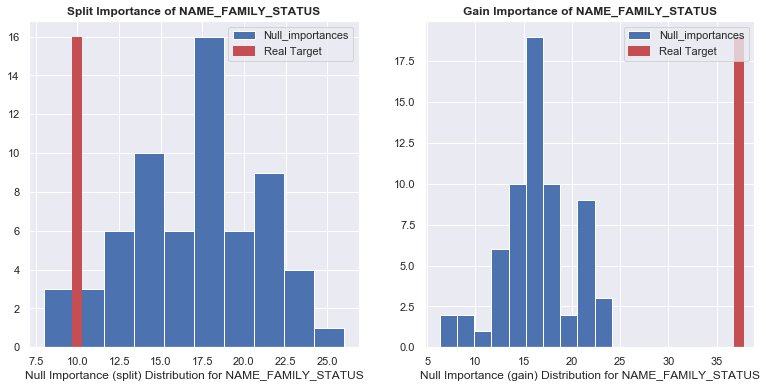

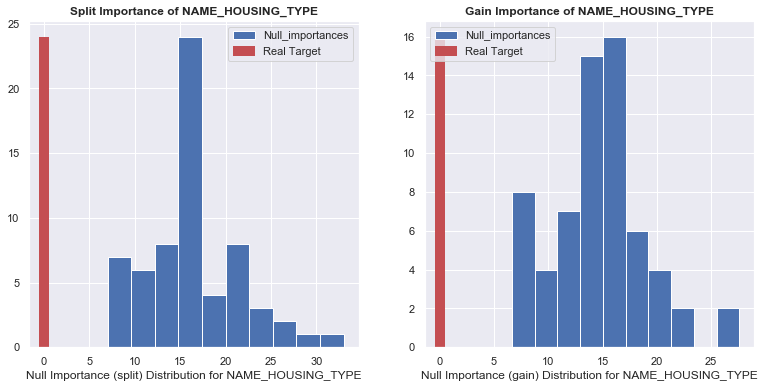

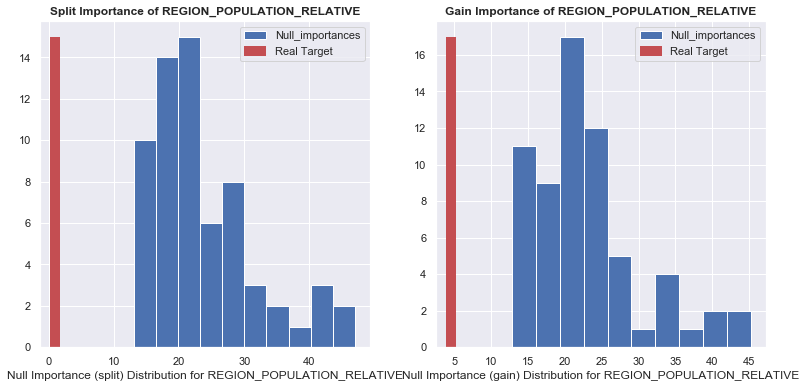

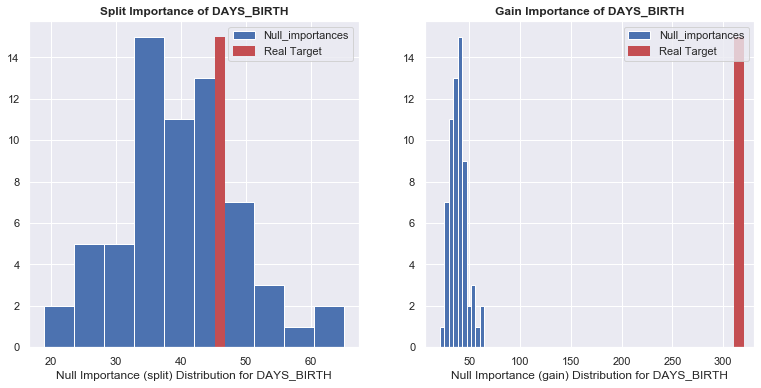

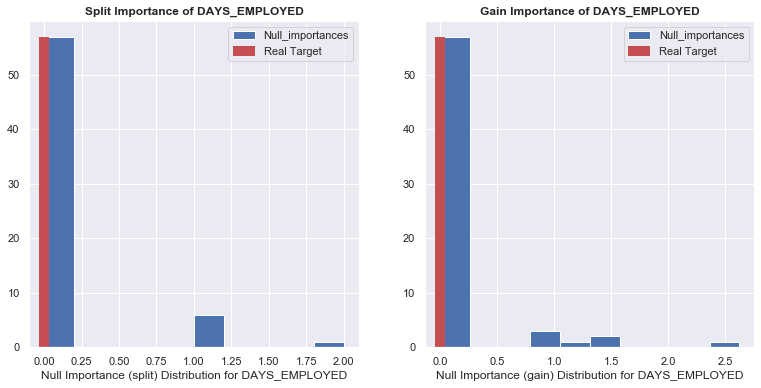

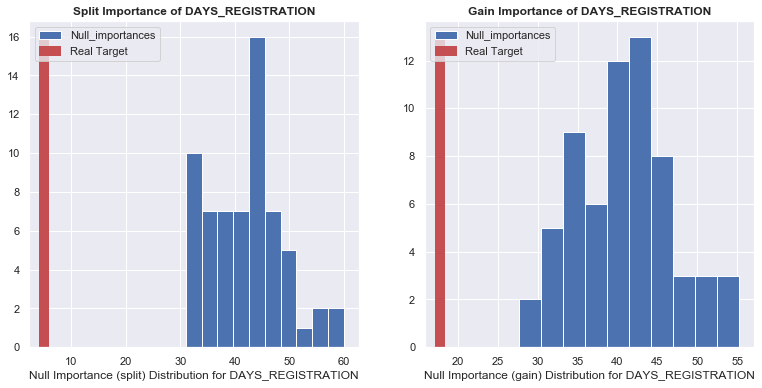

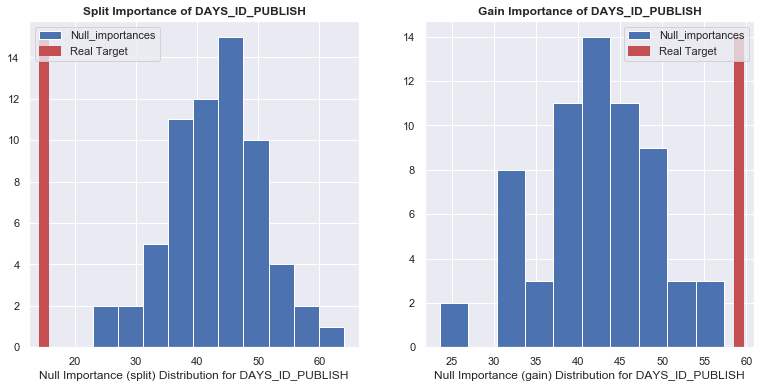

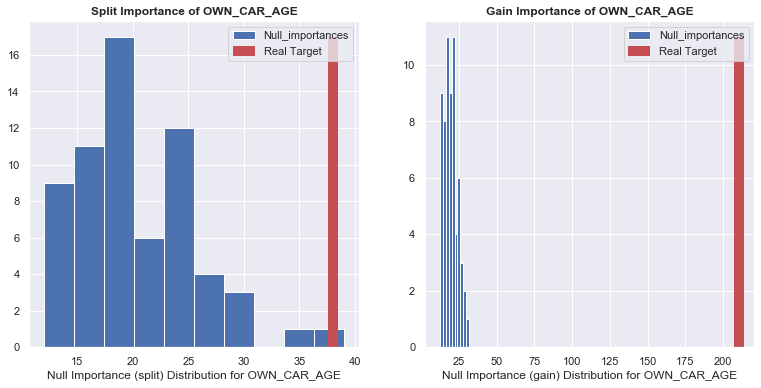

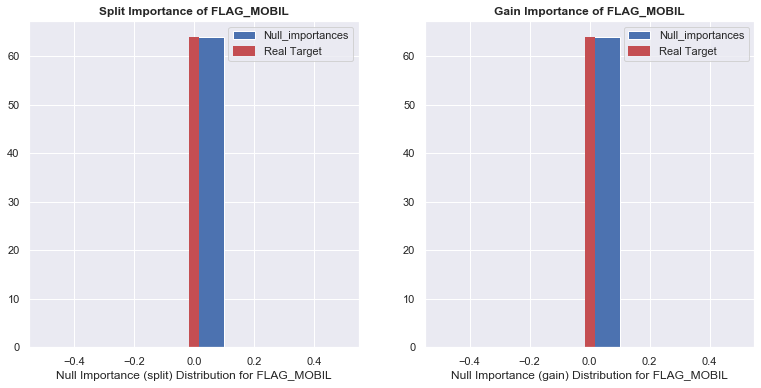

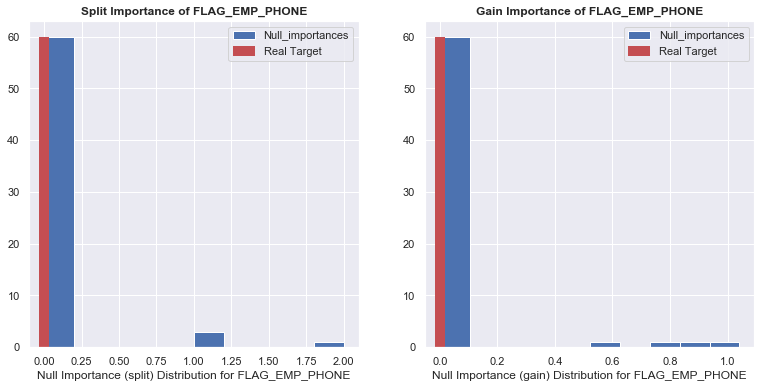

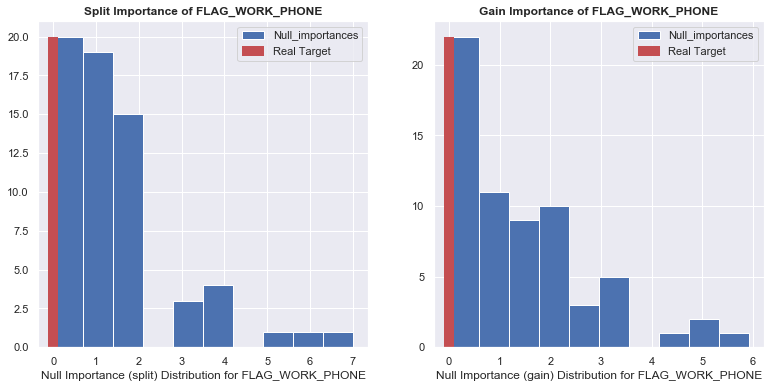

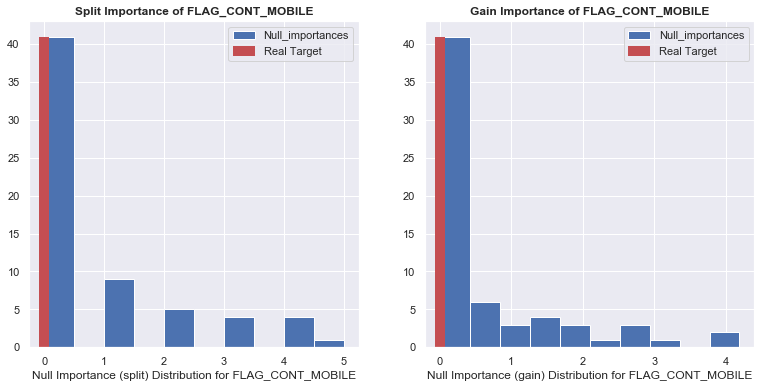

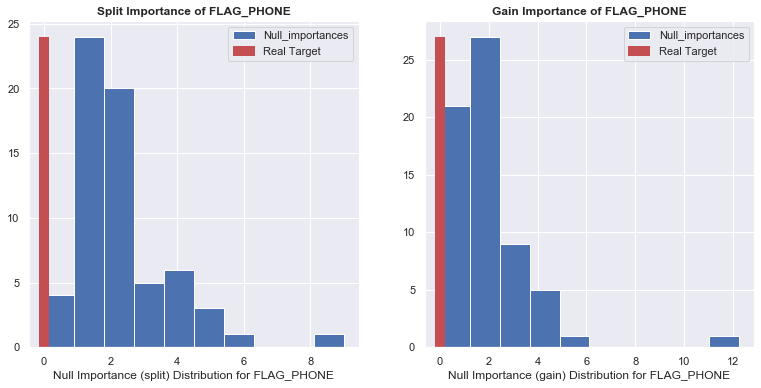

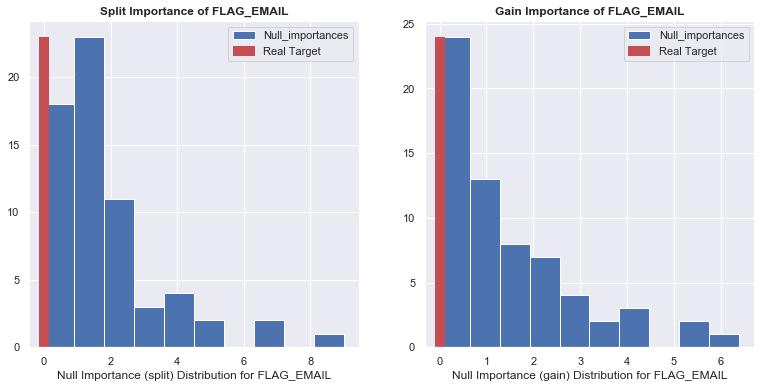

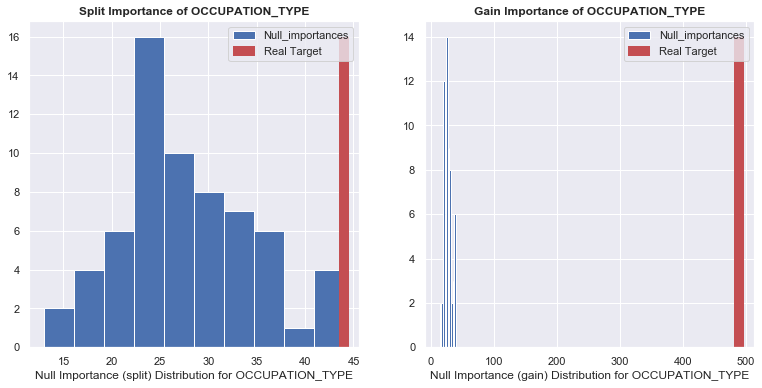

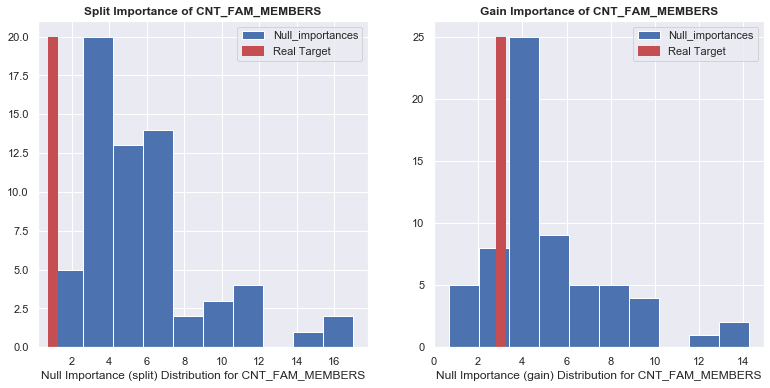

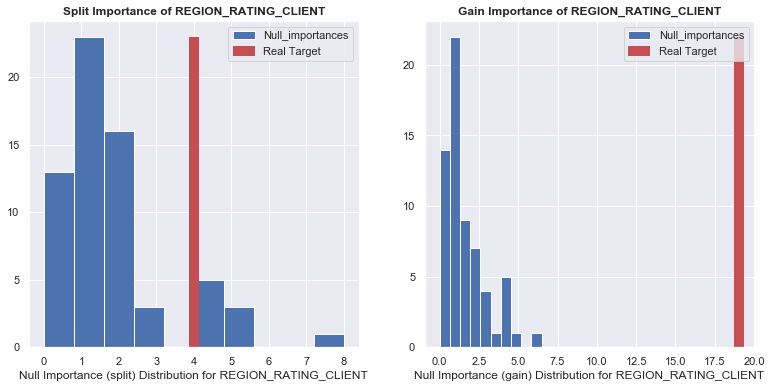

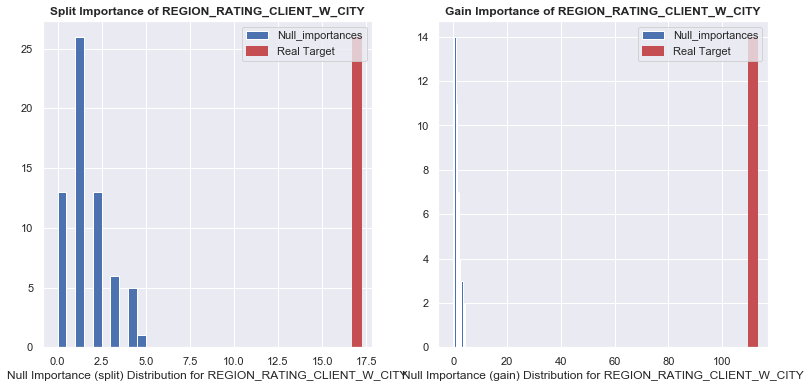

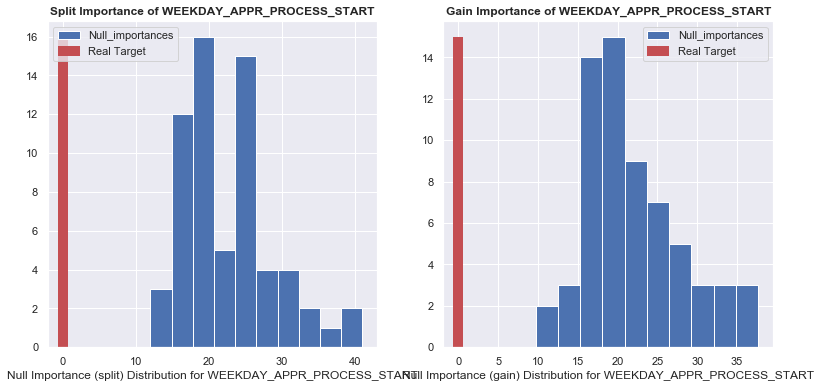

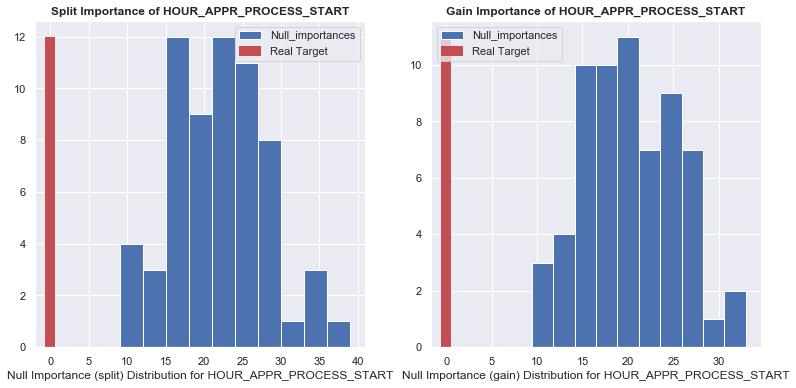

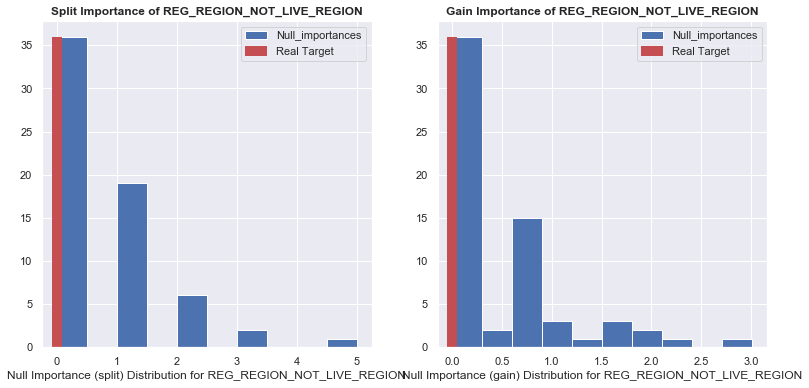

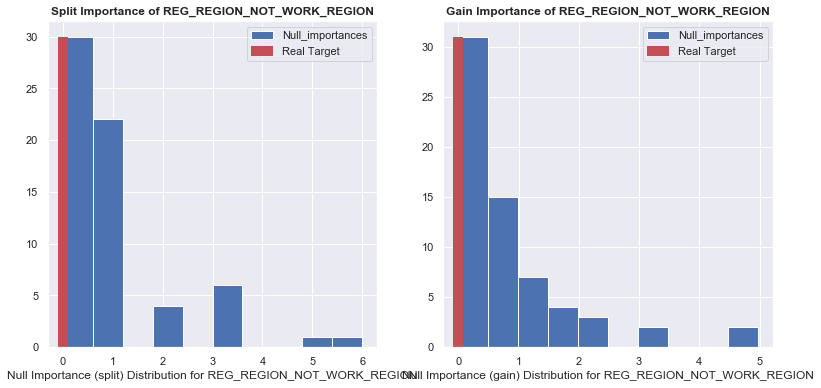

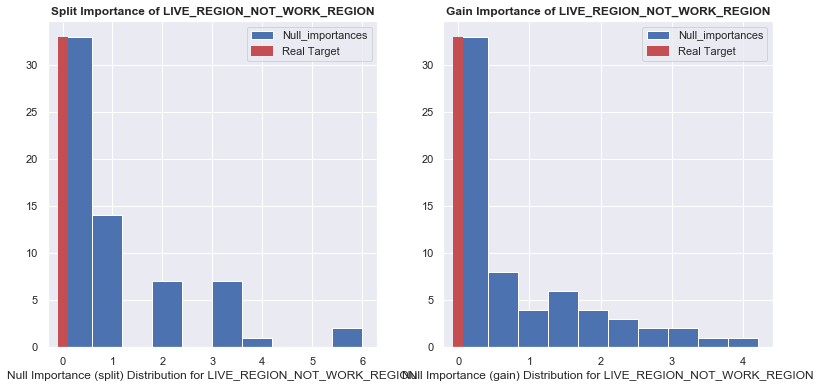

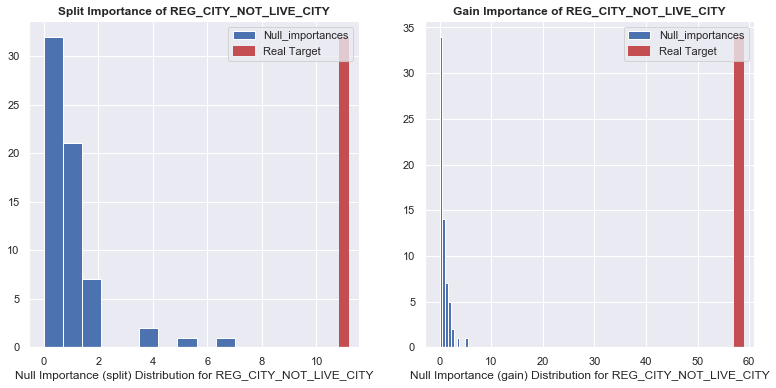

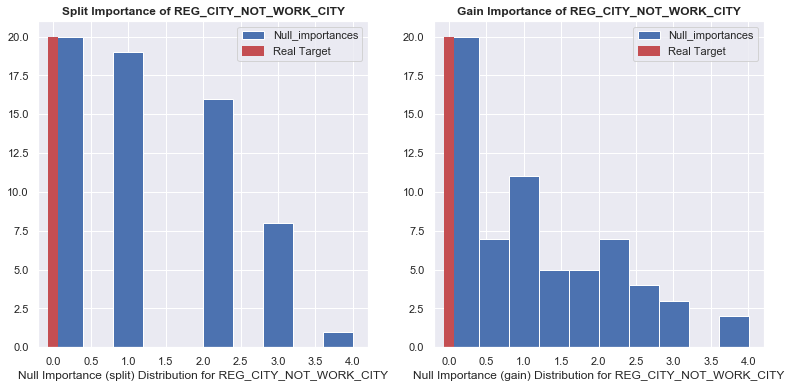

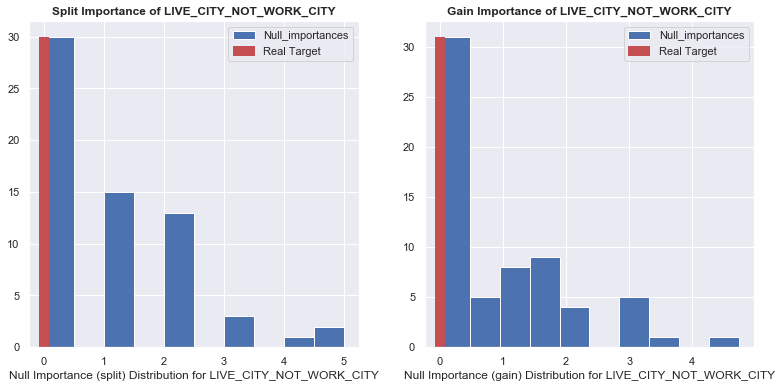

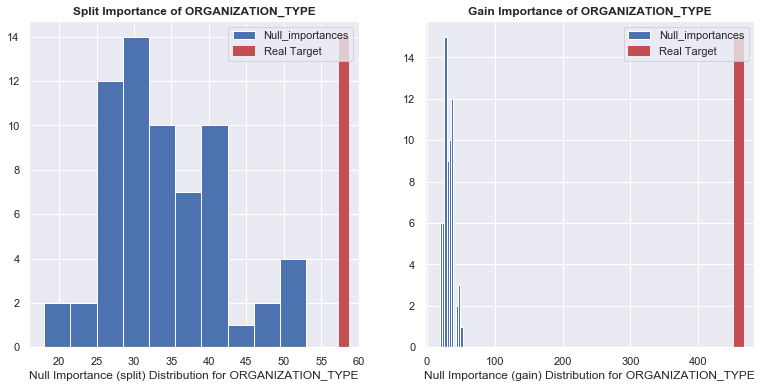

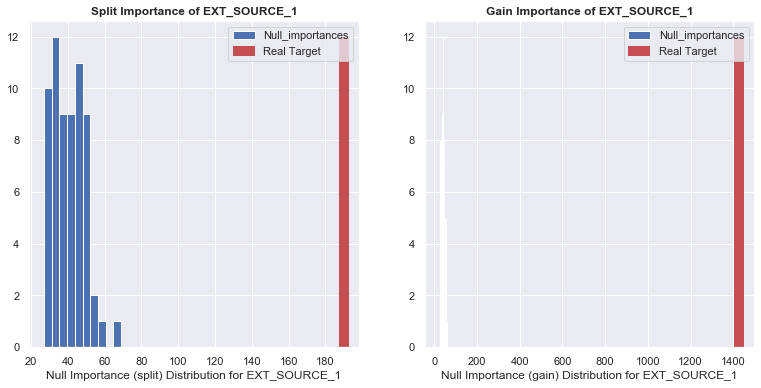

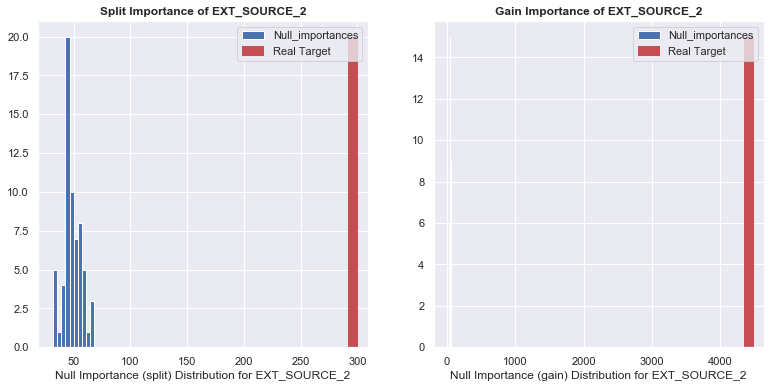

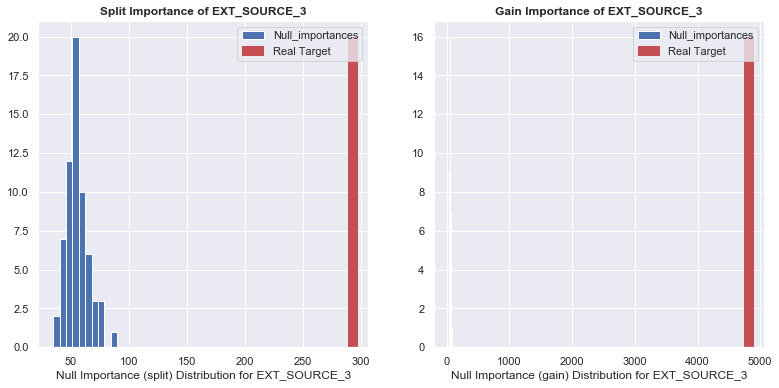

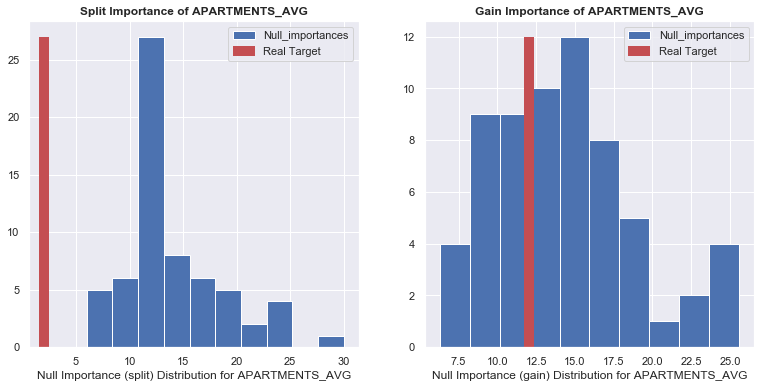

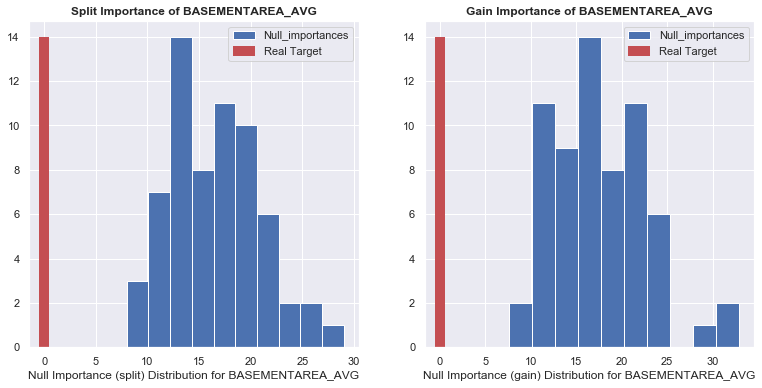

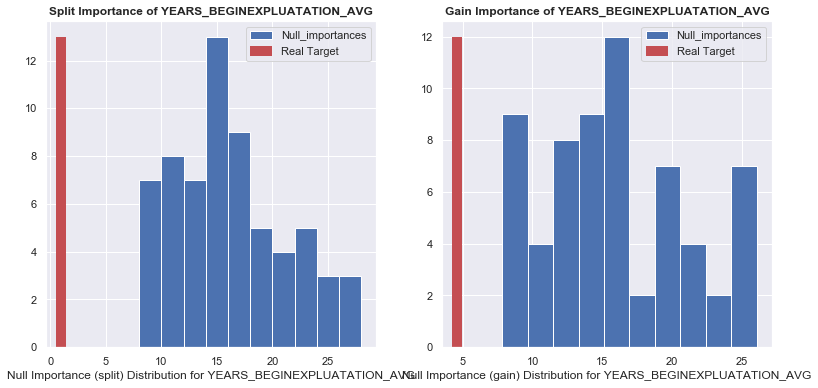

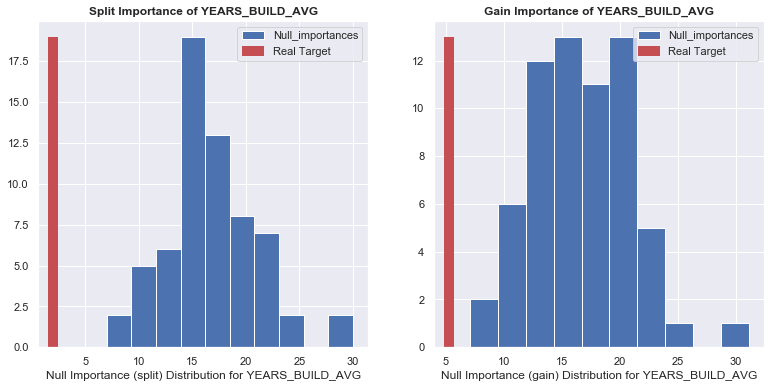

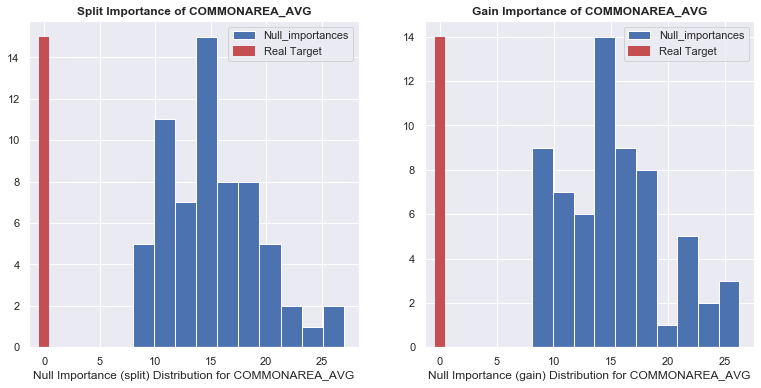

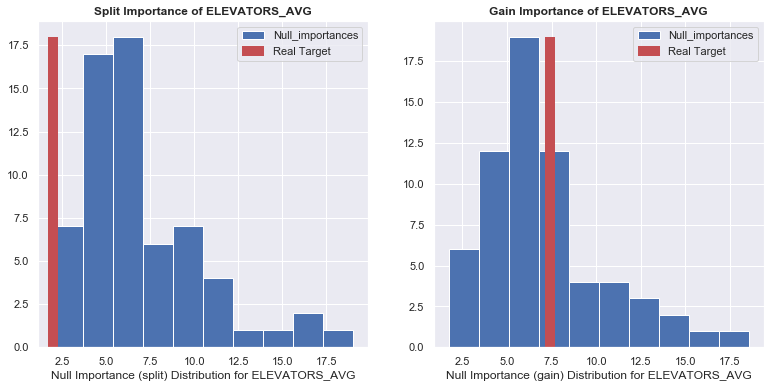

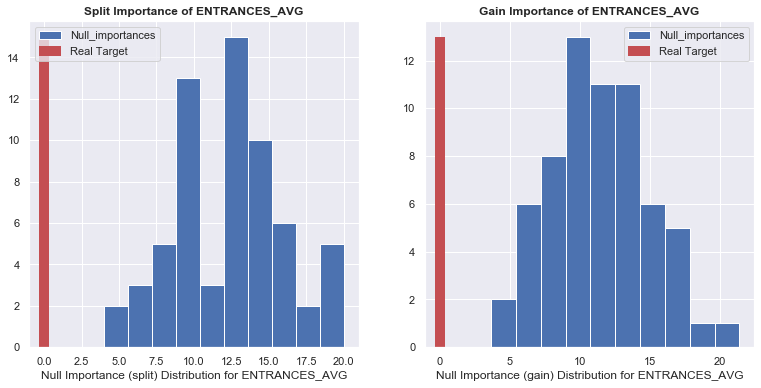

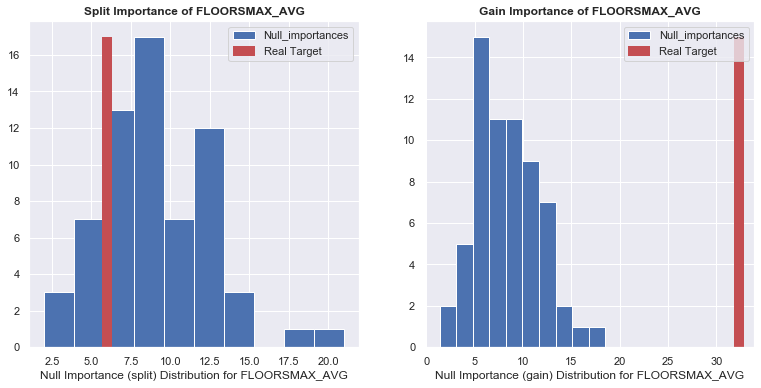

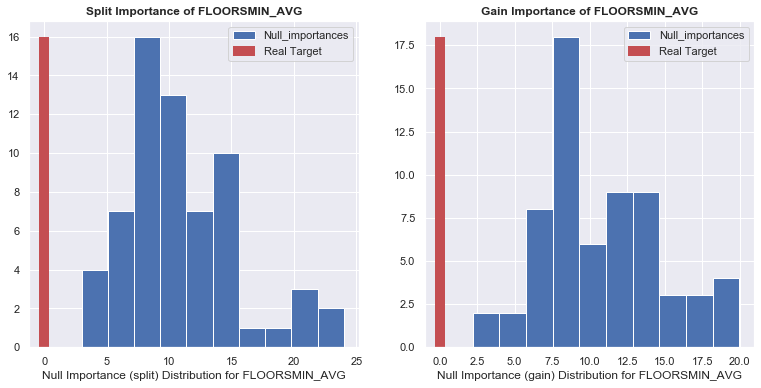

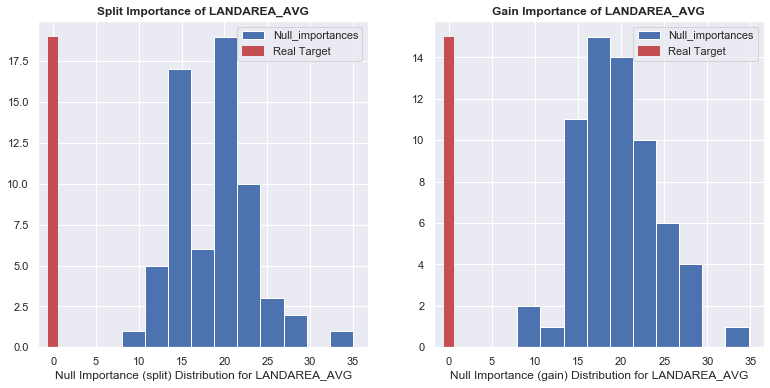

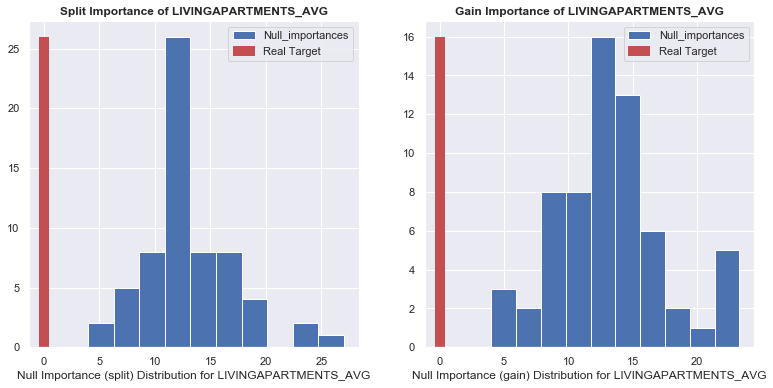

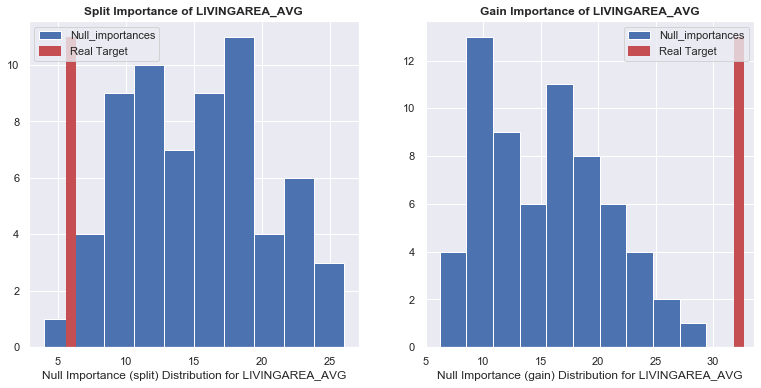

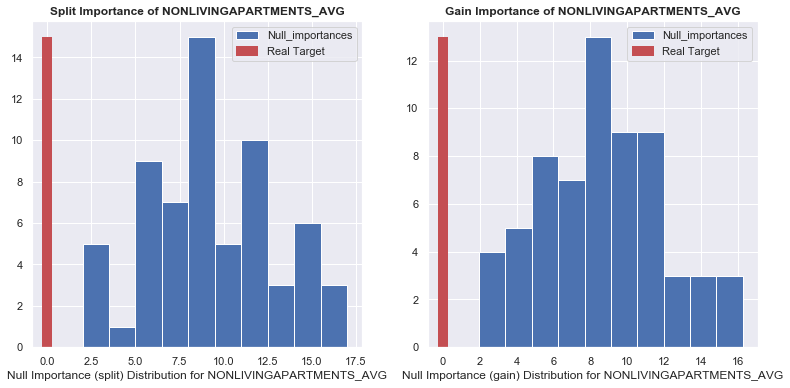

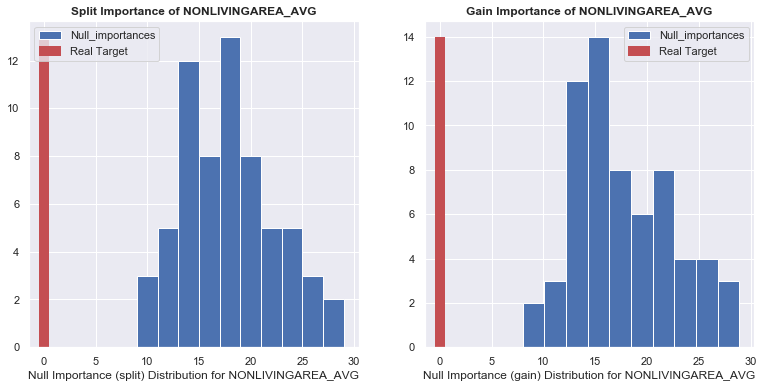

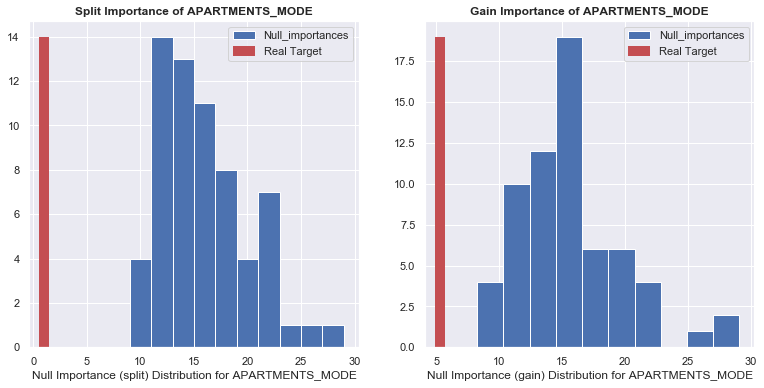

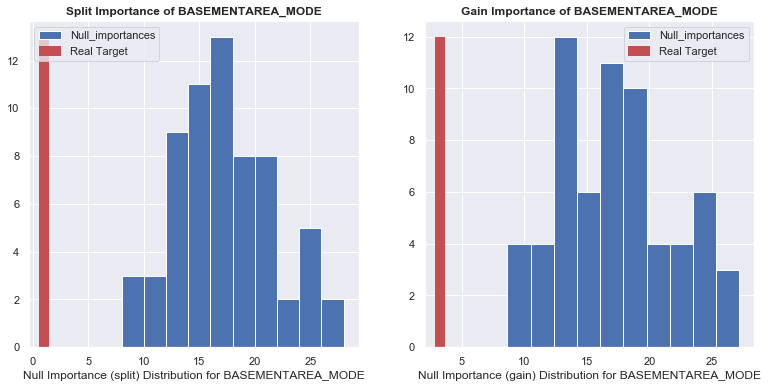

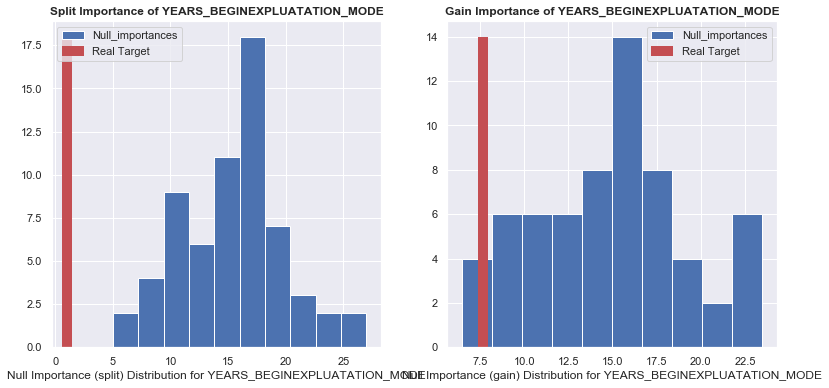

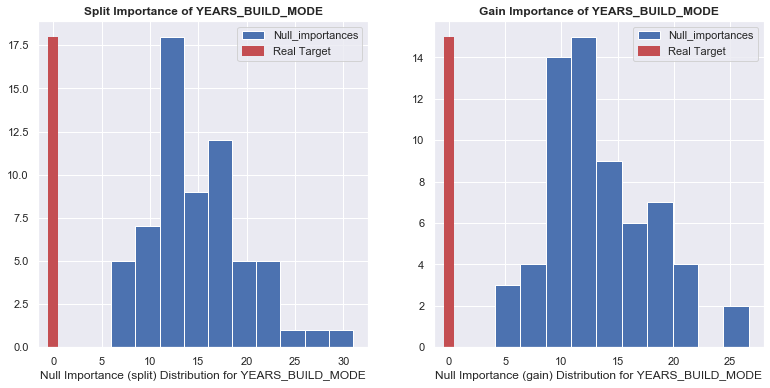

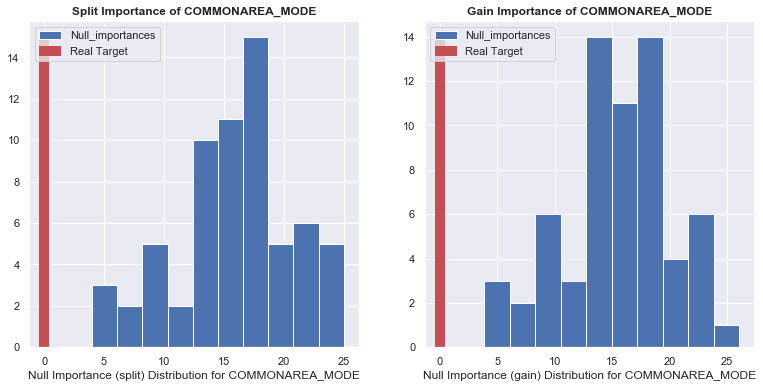

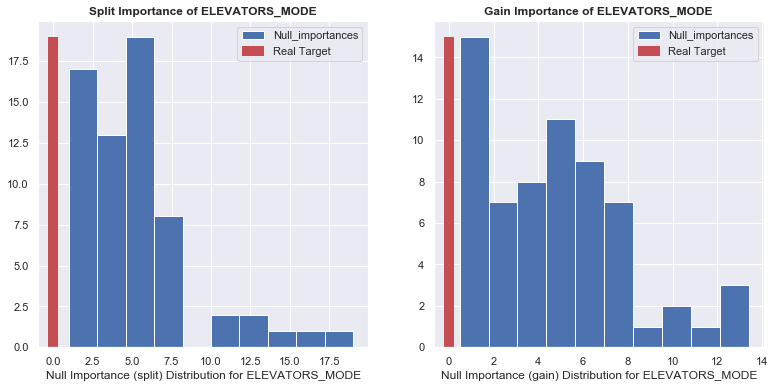

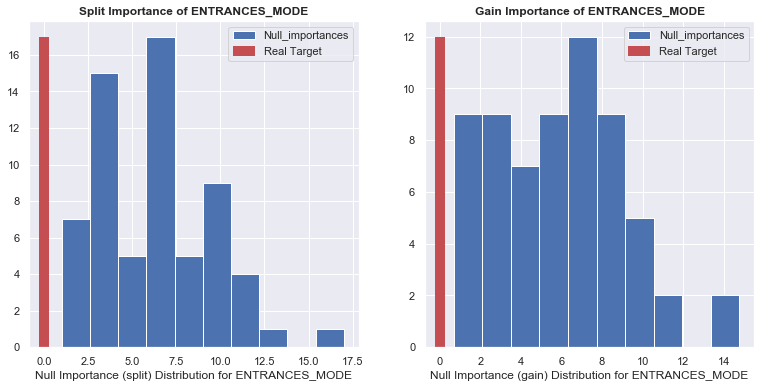

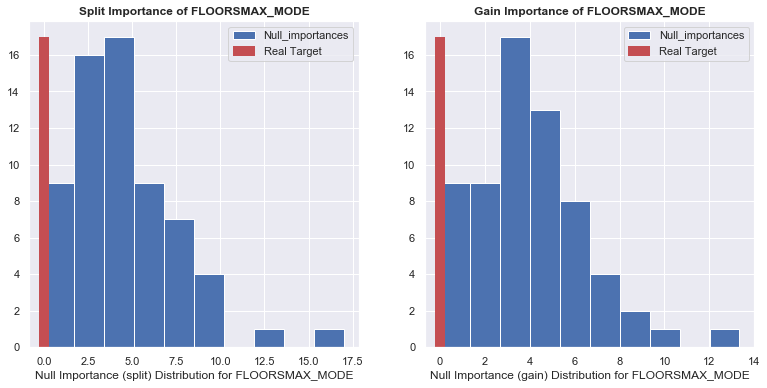

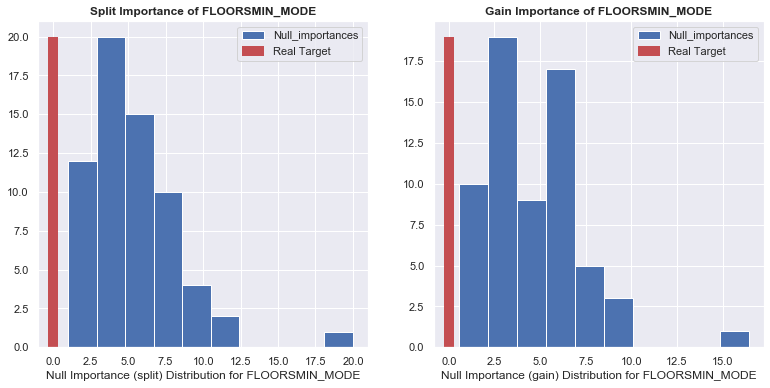

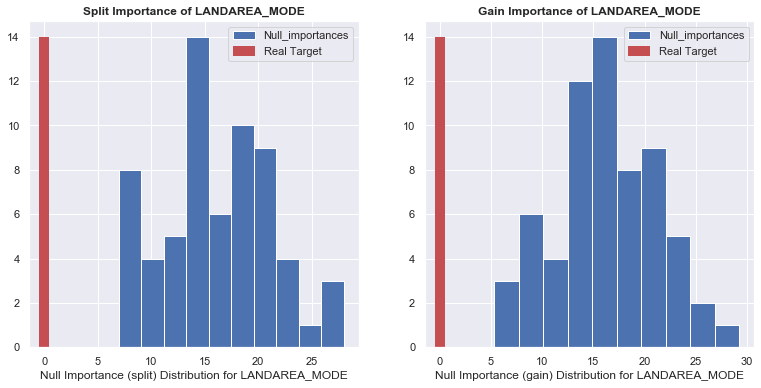

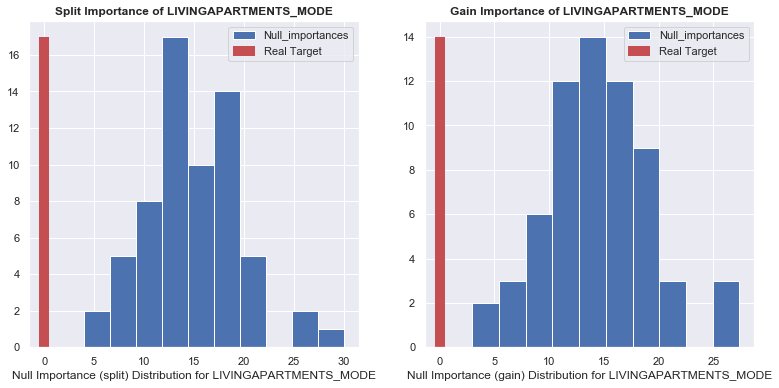

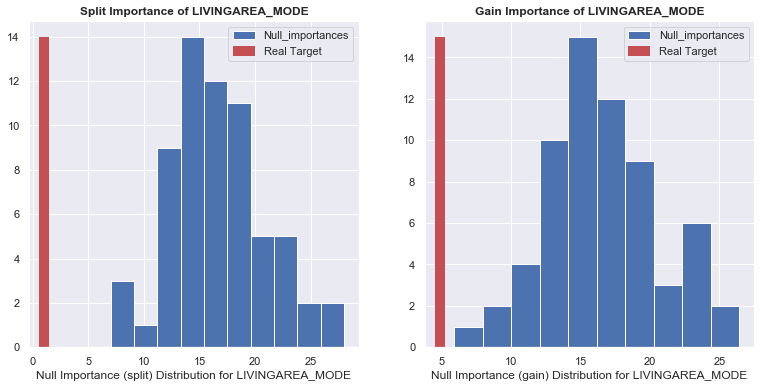

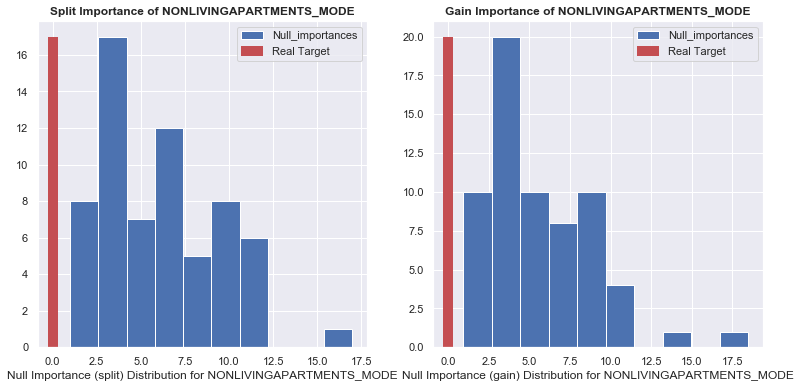

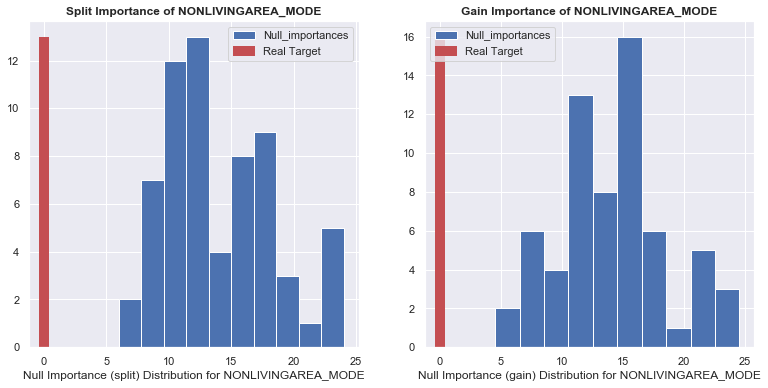

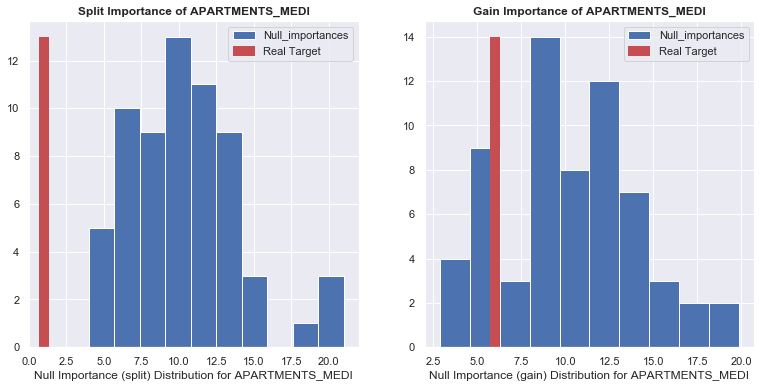

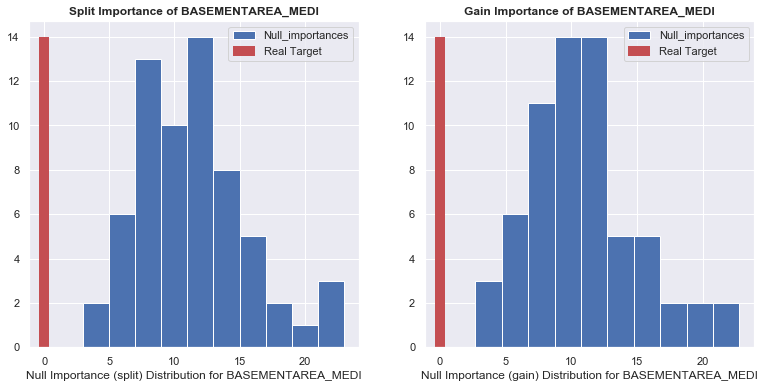

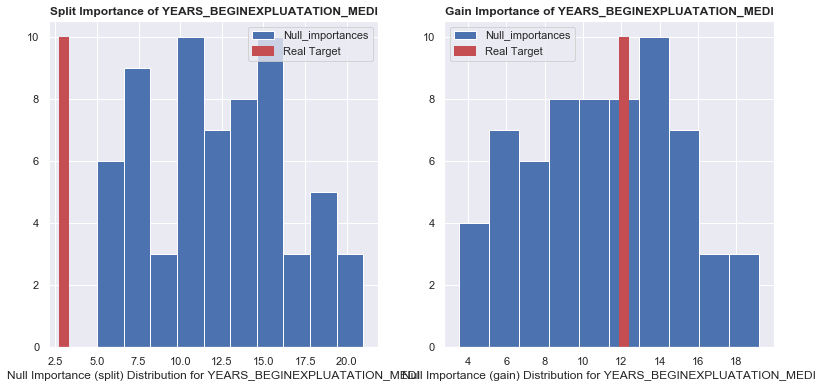

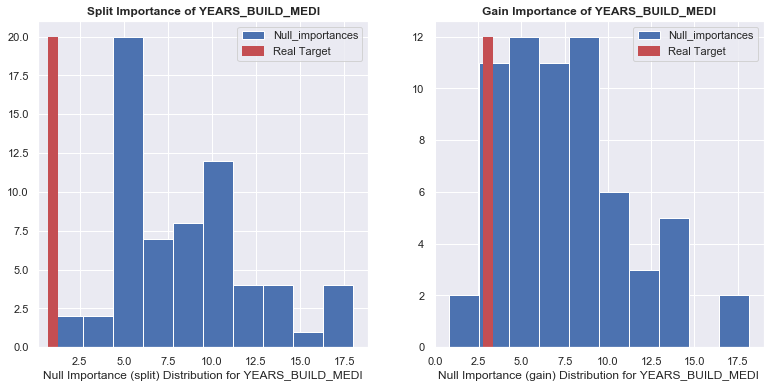

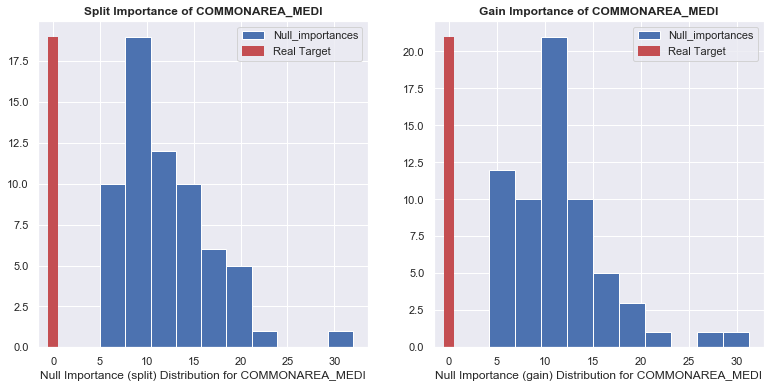

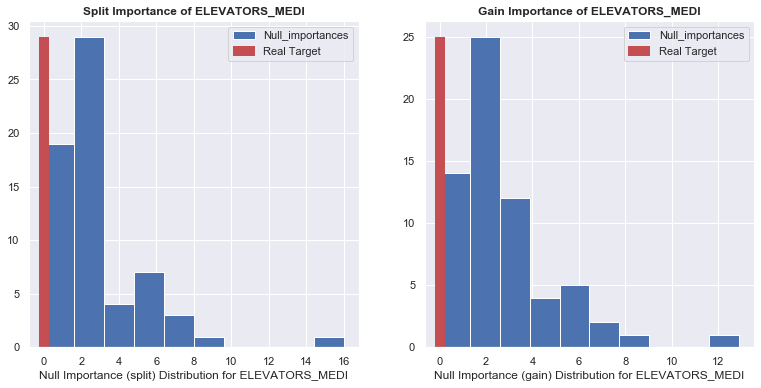

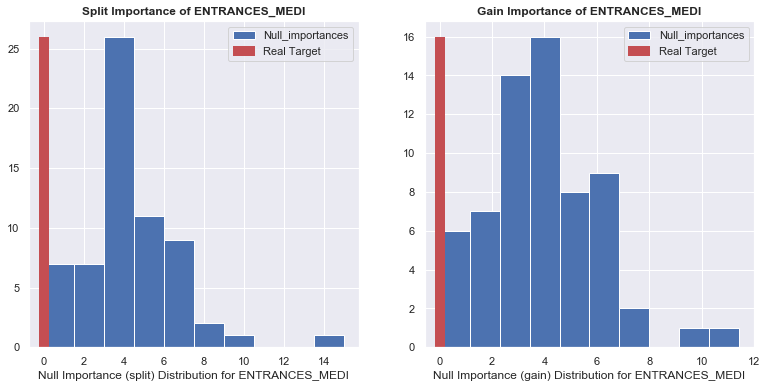

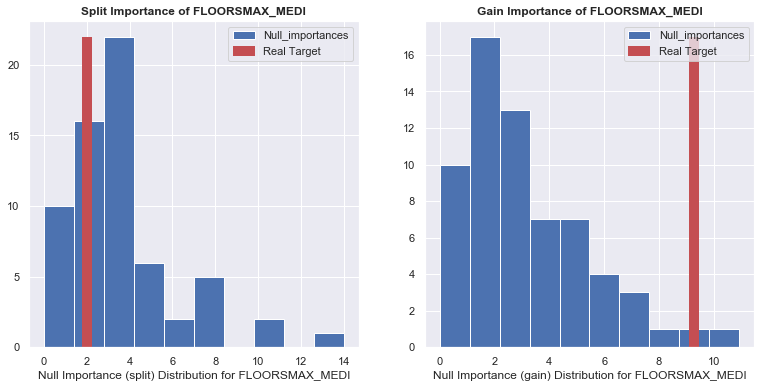

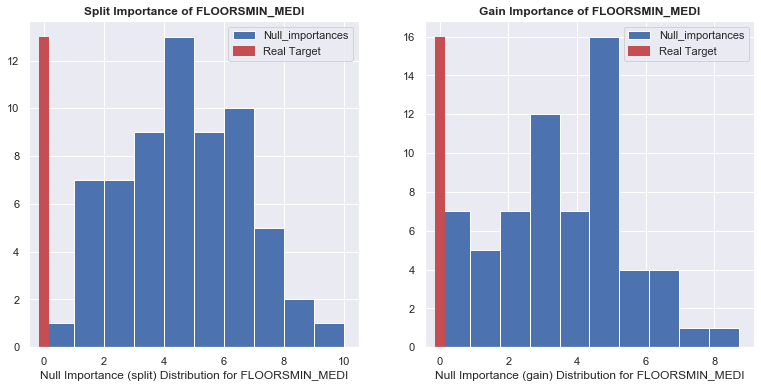

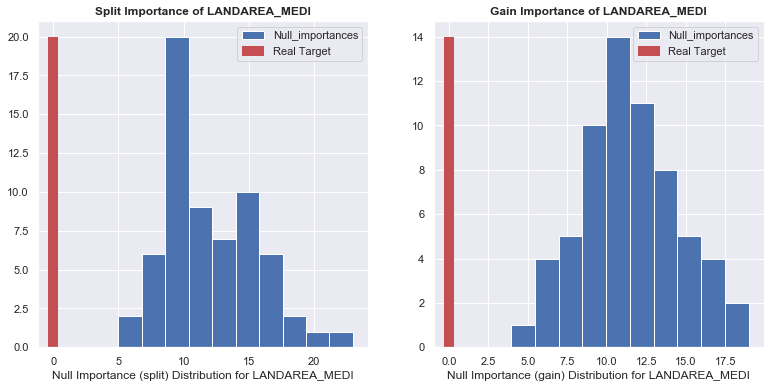

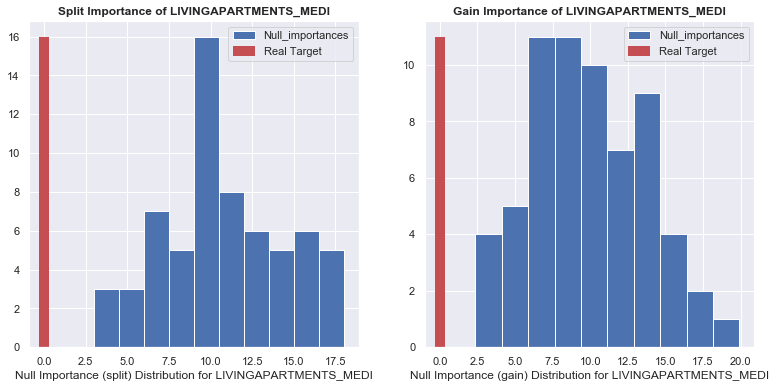

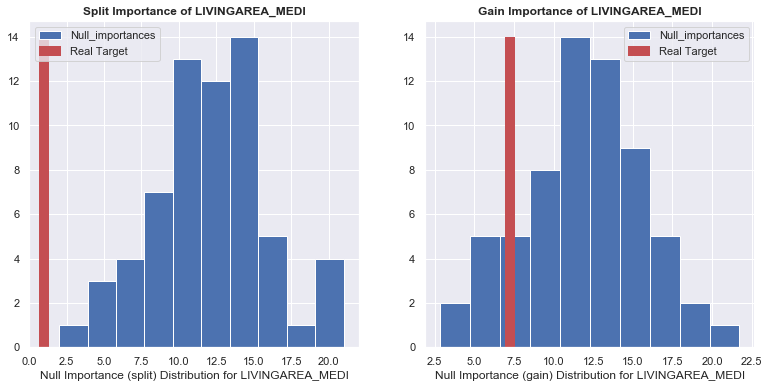

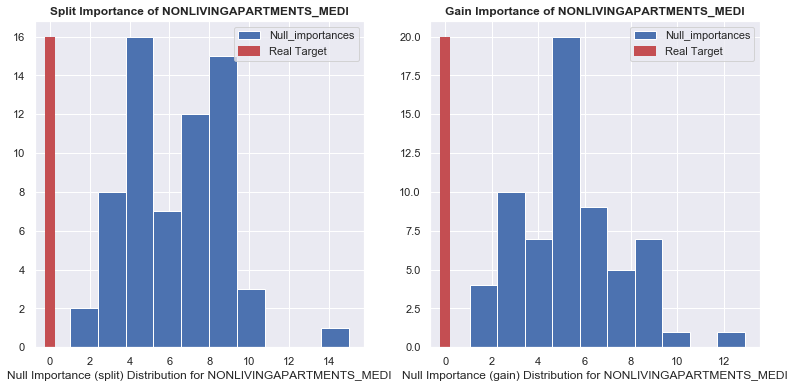

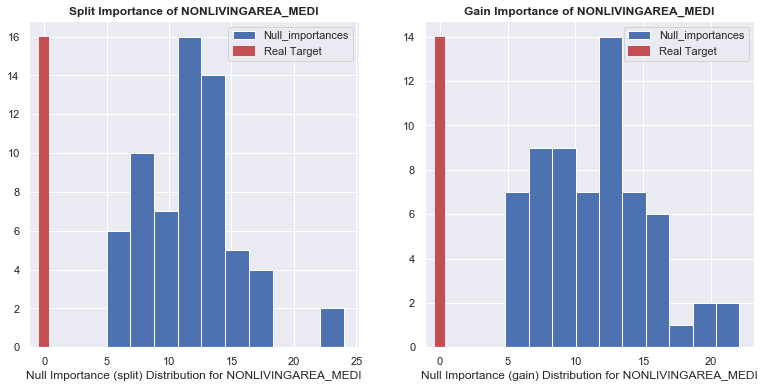

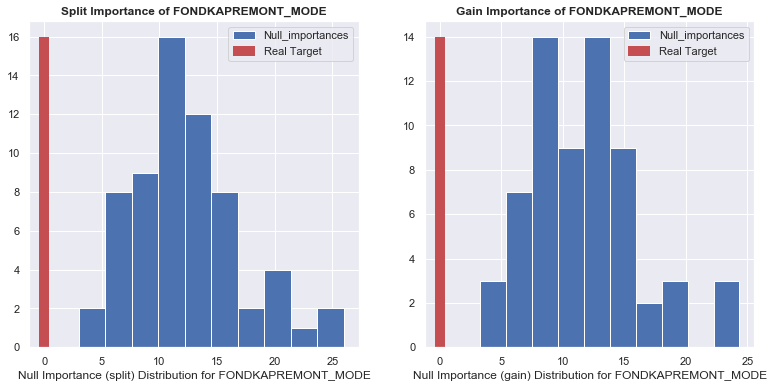

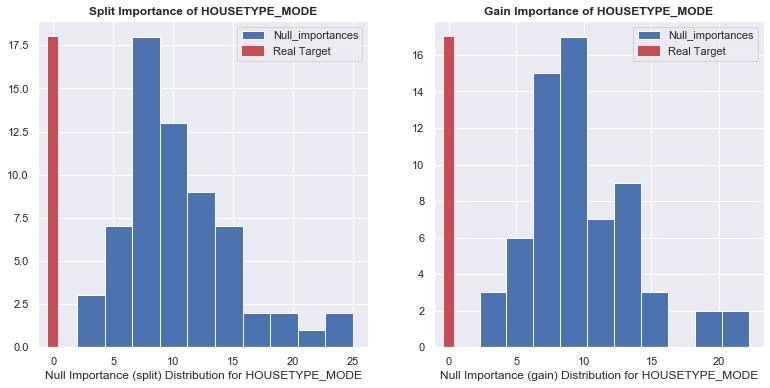

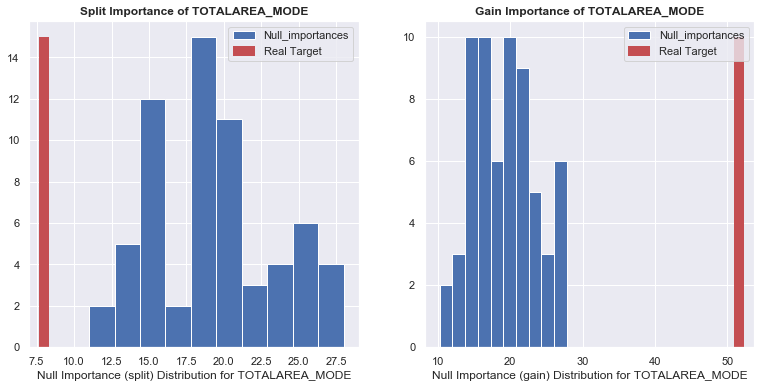

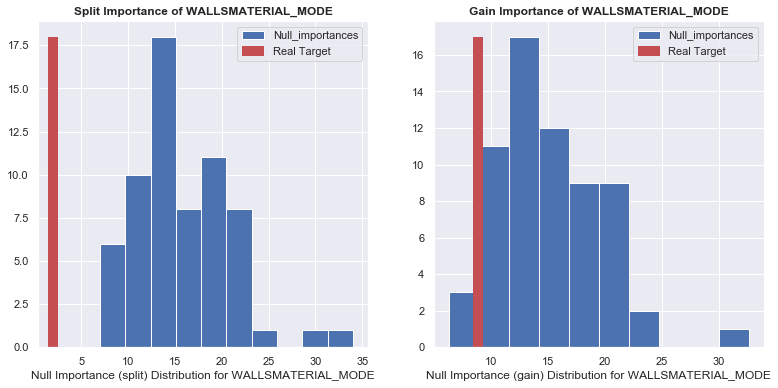

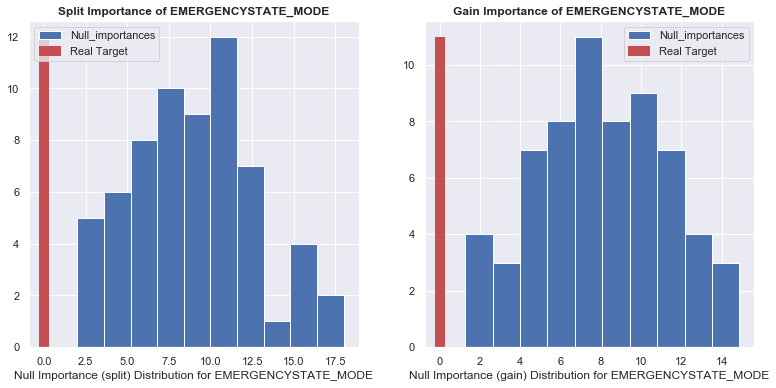

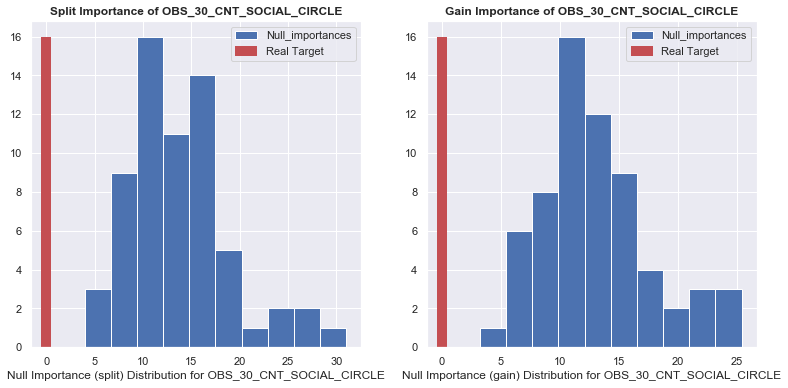

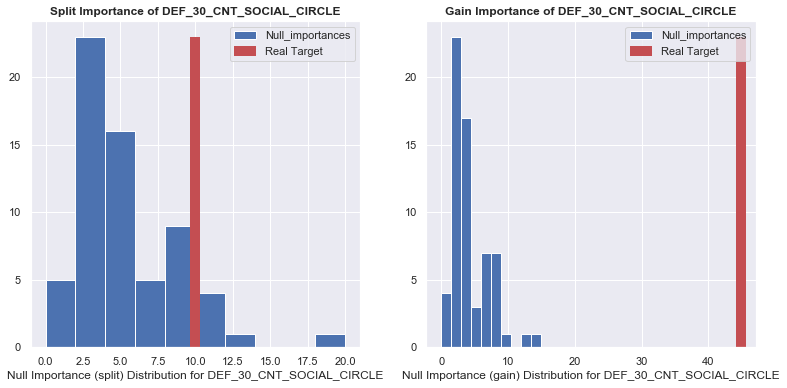

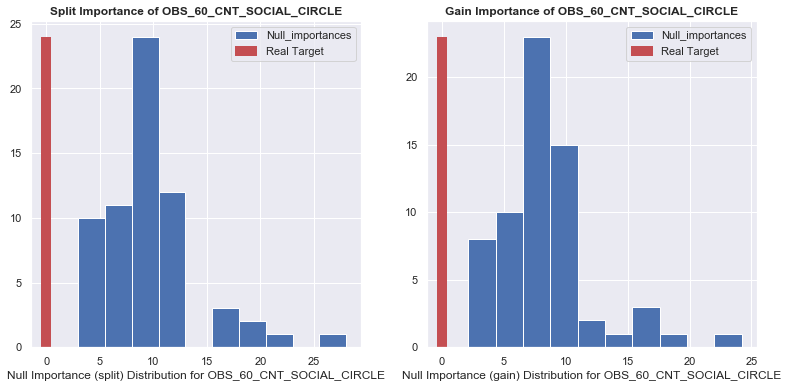

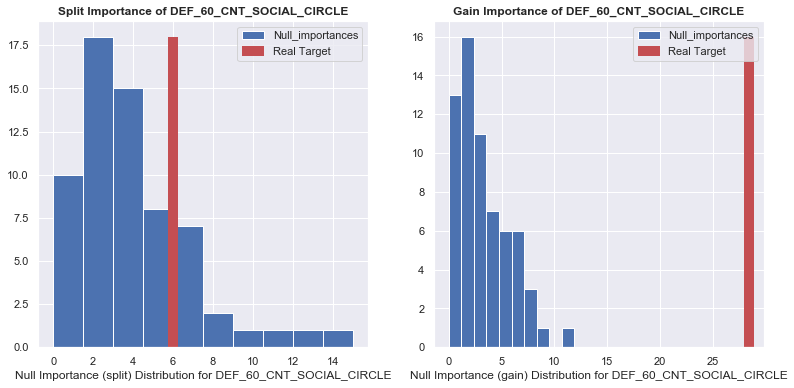

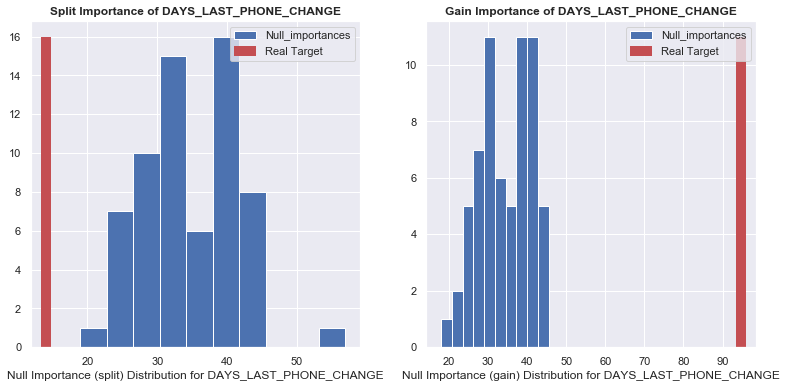

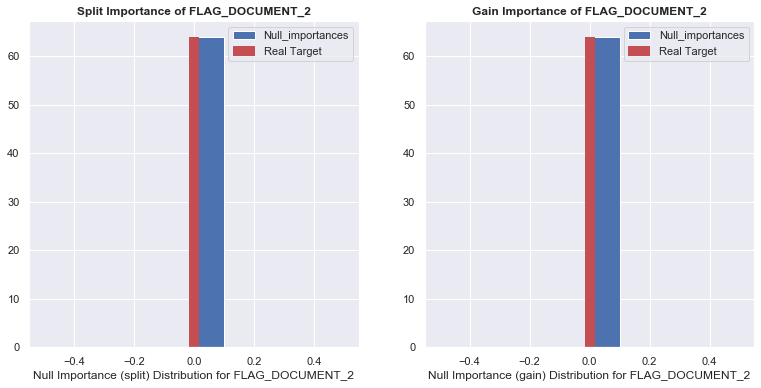

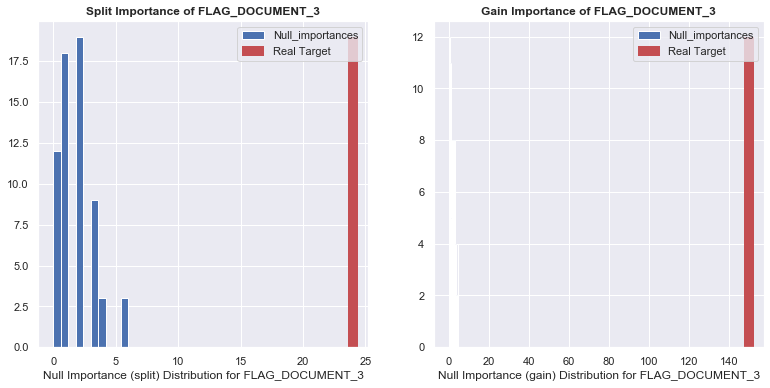

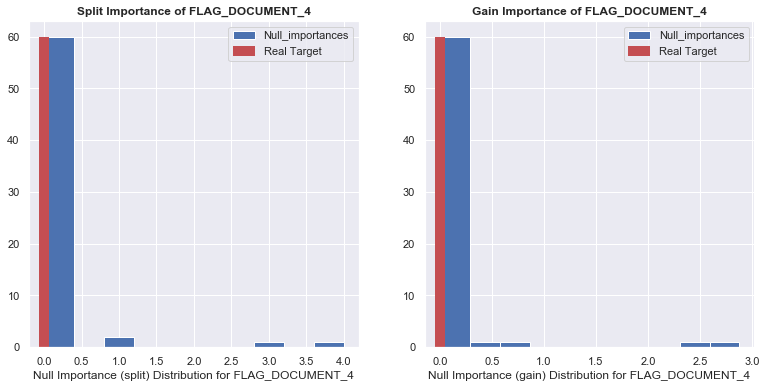

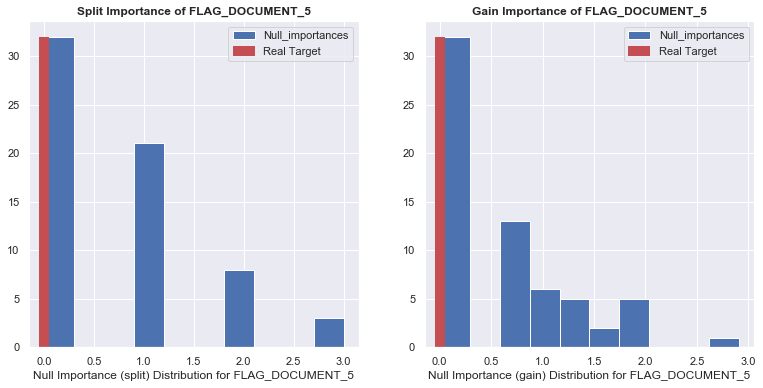

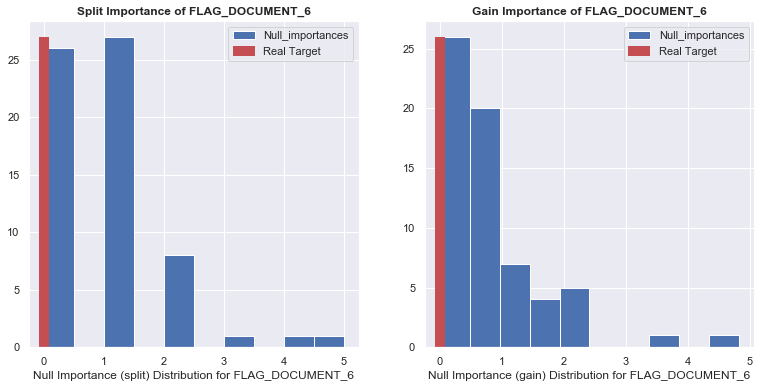

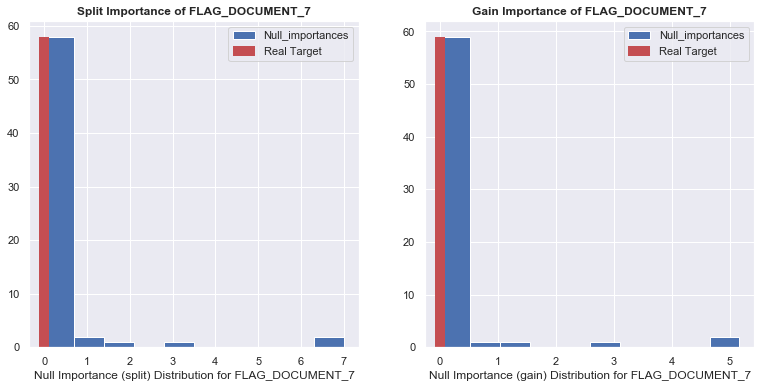

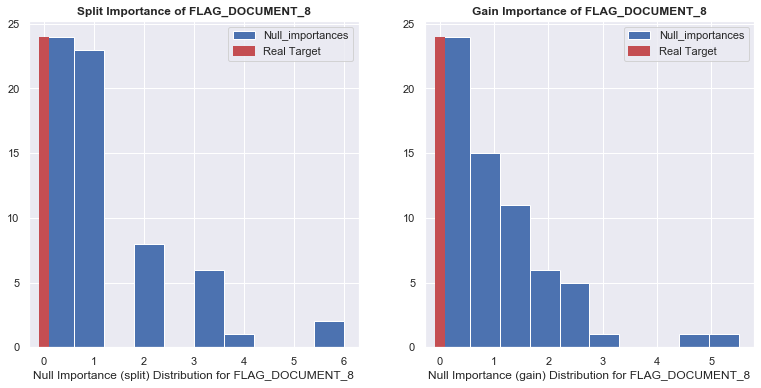

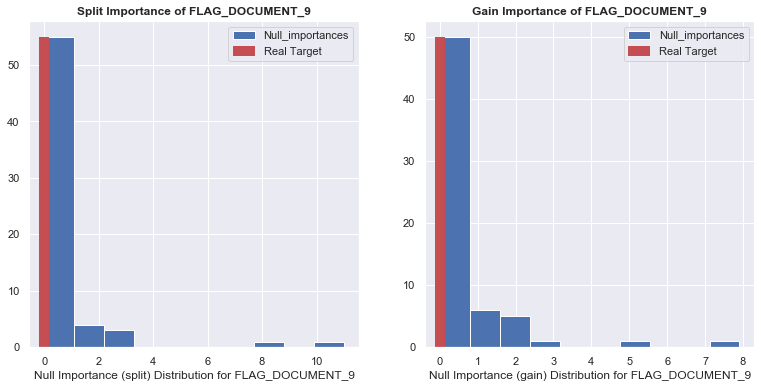

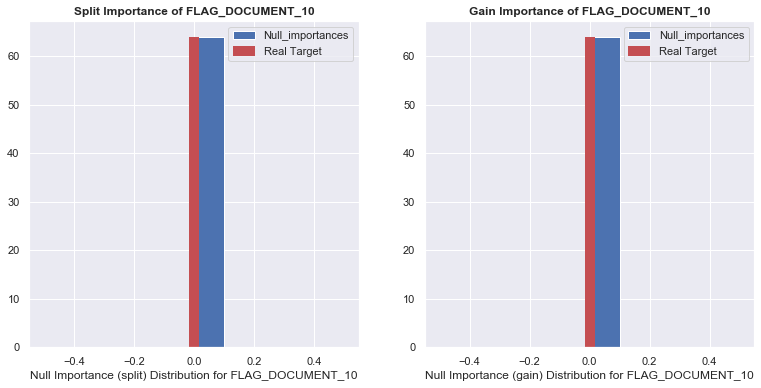

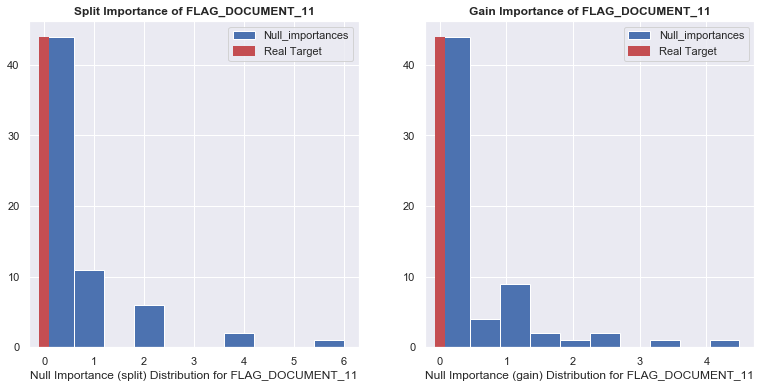

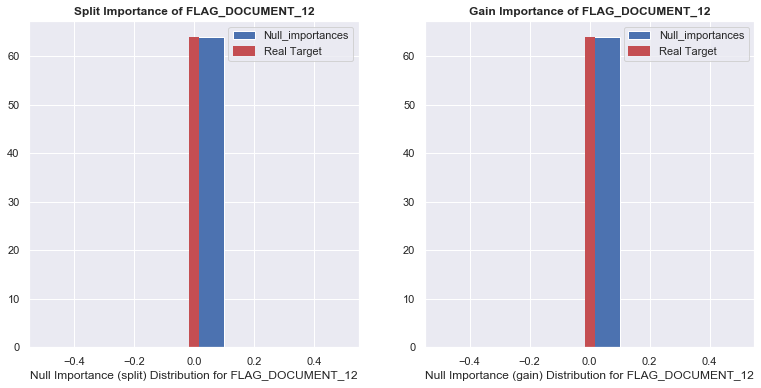

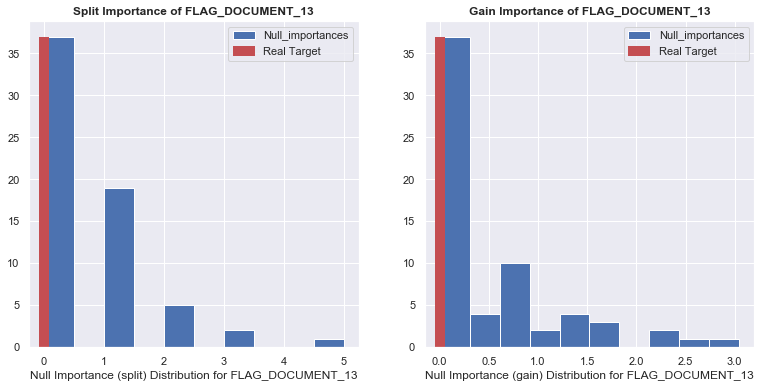

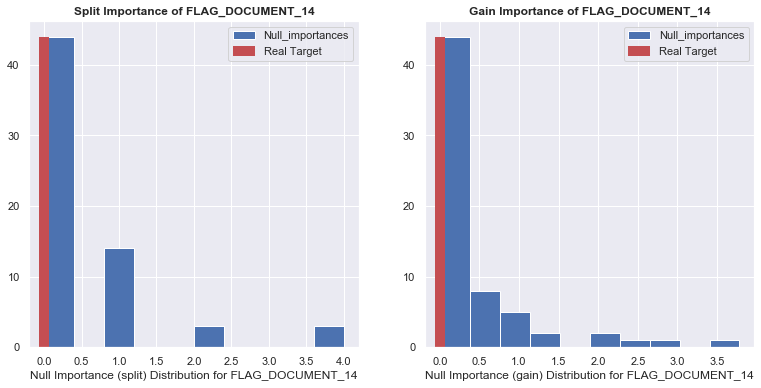

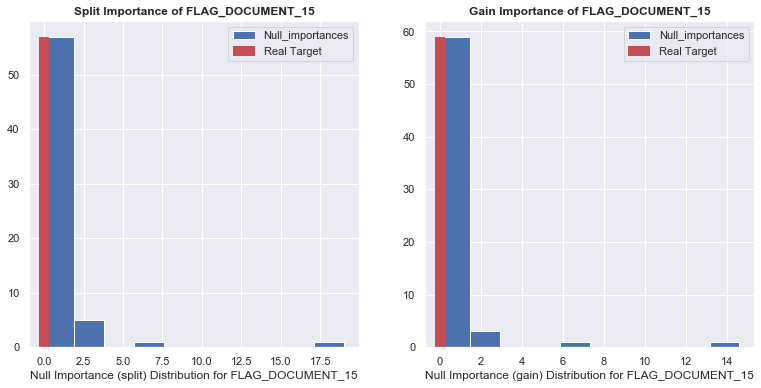

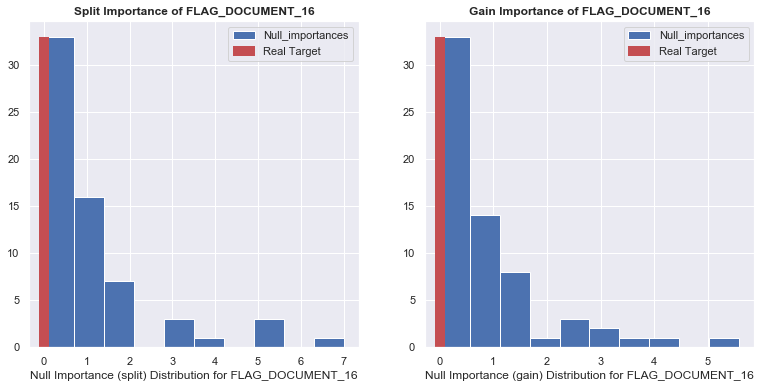

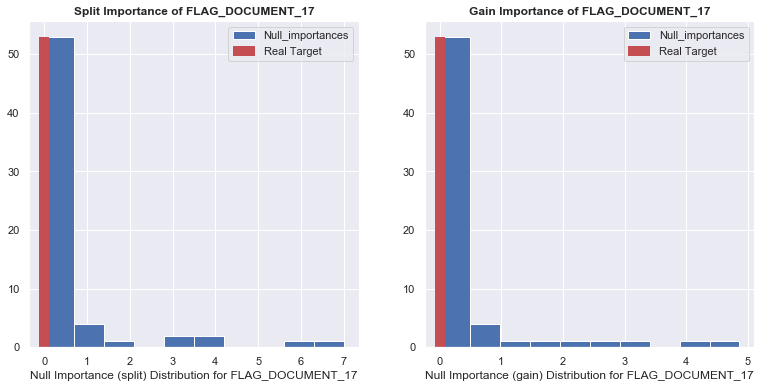

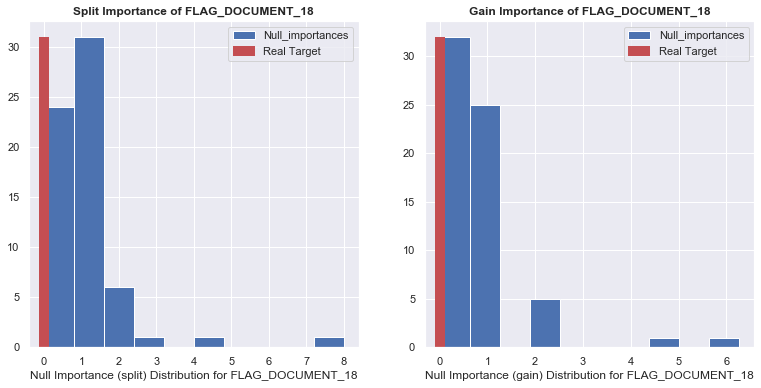

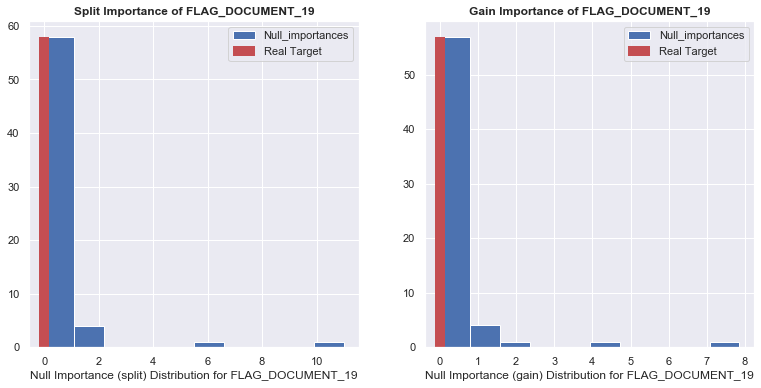

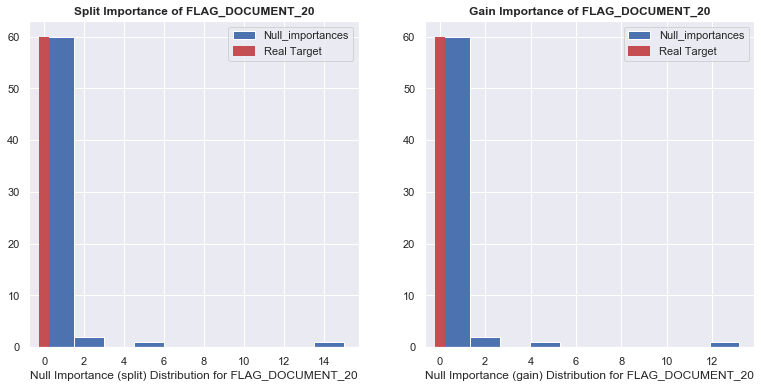

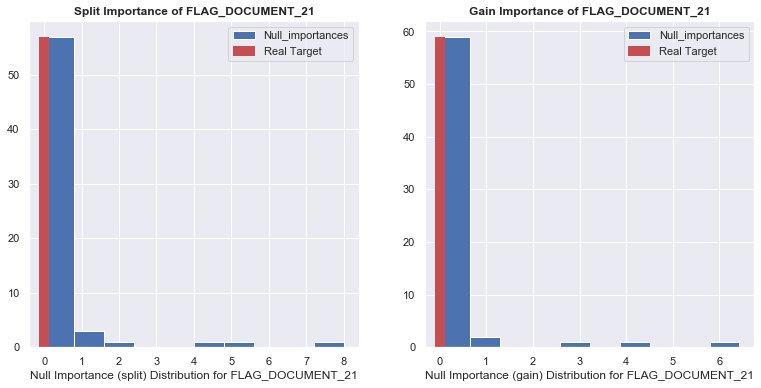

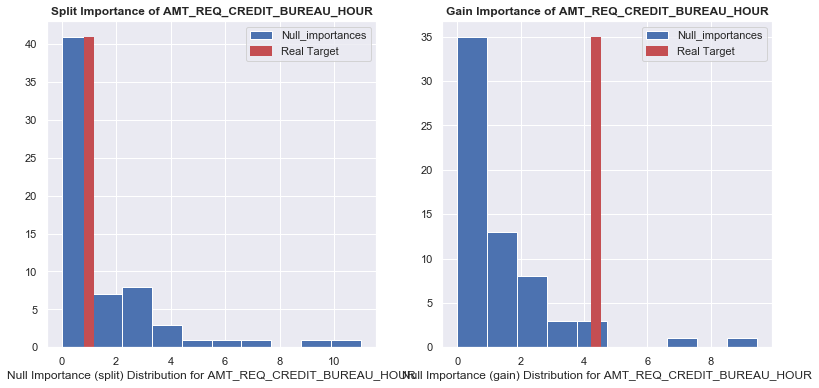

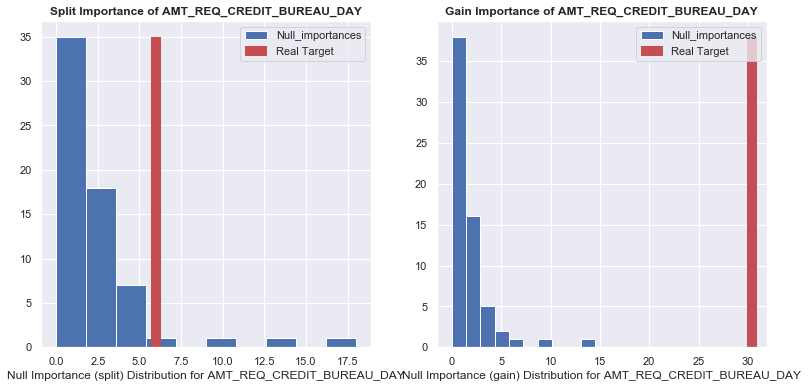

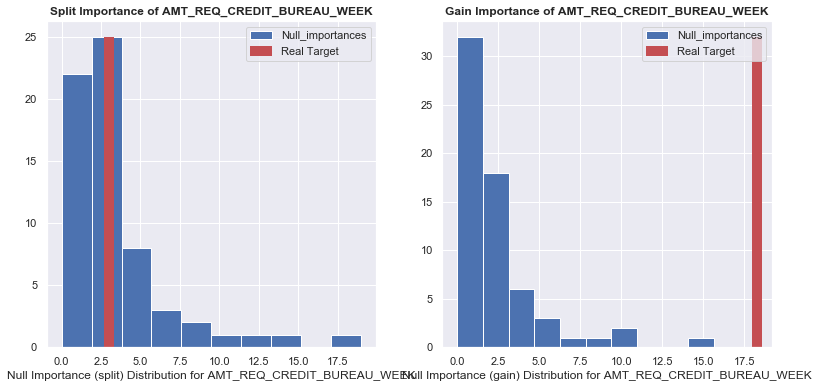

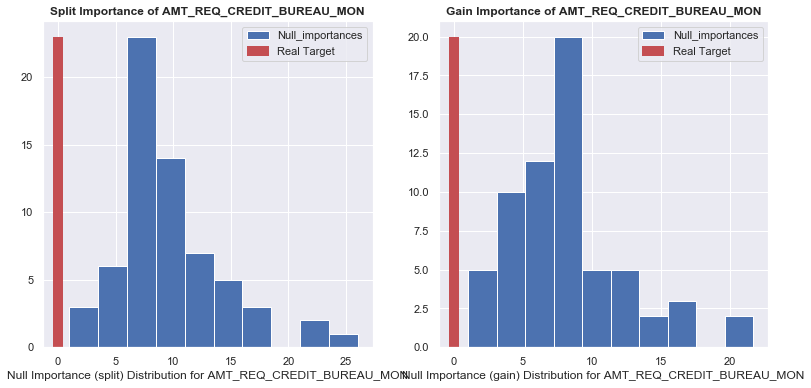

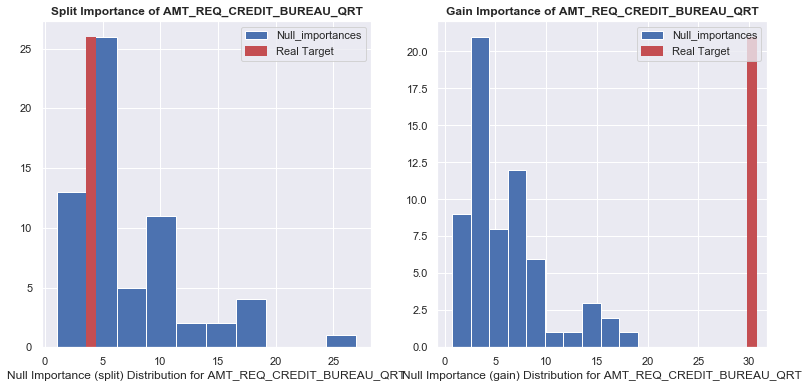

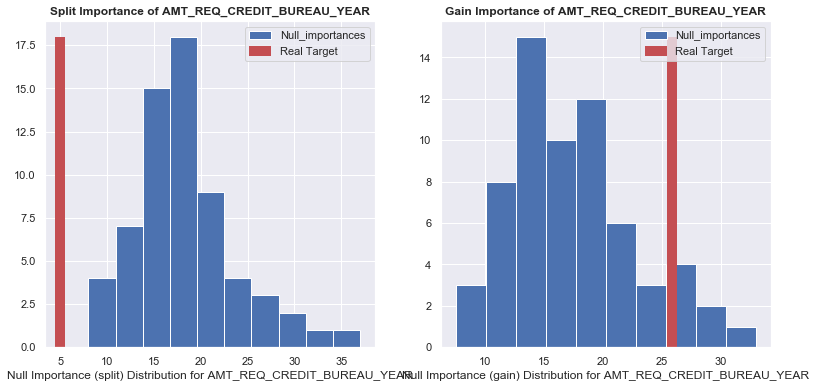

In [19]:
for feature in actual_imp_df['feature']:
    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=feature)

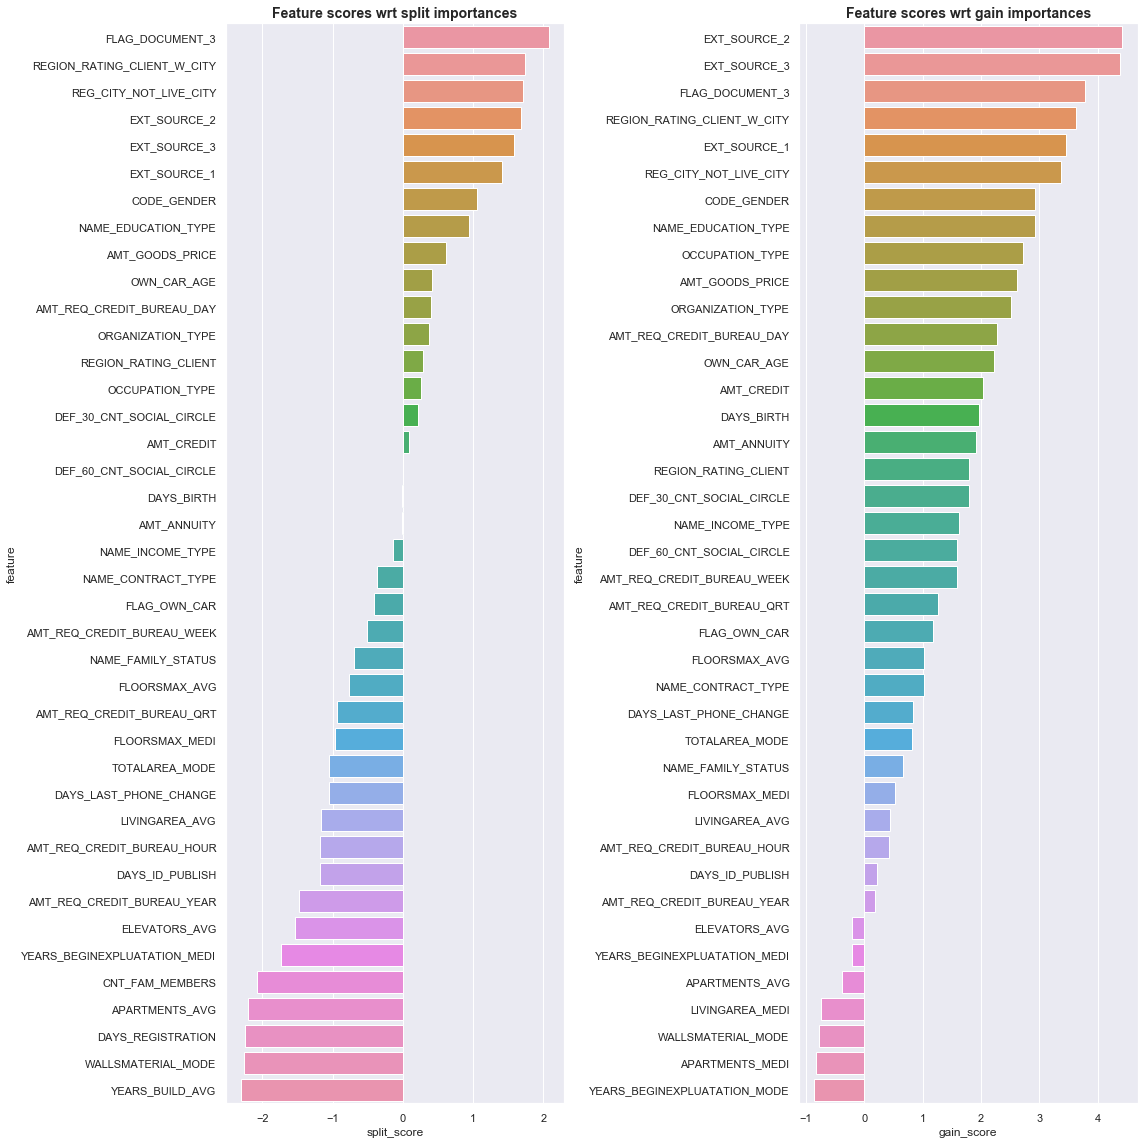

In [20]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature']==_f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature']==_f, 'importance_gain'].mean()
    gain_score = np.log(1e-6 + f_act_imps_gain/(1+np.percentile(f_null_imps_gain, 75)))
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature']==_f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature']==_f, 'importance_split'].mean()
    split_score = np.log(1e-6 + f_act_imps_split/(1+np.percentile(f_null_imps_split, 75)))
    feature_scores.append((_f, split_score, gain_score))
    
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])
    
plt.figure(figsize=(16, 16))
gs = GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:40], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:40], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

### Permutation importanceの評価

In [21]:
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

def auc(y_test, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    return metrics.auc(fpr, tpr)

def permuted(df):
    for columns_name in df.columns:
        permuted_df = df.copy()
        permuted_df[columns_name] = np.random.permutation(permuted_df[columns_name])
        yield columns_name, permuted_df
        
def pimp(X, y, cv=None, eval_func=auc):
    """
    permutation importance
    """
    base_scores = []
    permuted_scores = defaultdict(list)
    
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
    params = {'boosting_type': 'dart',
          'colsample_bytree': 0.64,
          'learning_rate': 0.03,
          'max_bin': 255,
          'metric': 'auc',
          'n_estimators': 128,
          'num_leaves': 16,
          'objective': 'regression',
          'ramdom_state': 0,
          'reg_alpha': 0.8, 
          'reg_lambda': 1, 
          'subsample': 0.5
         }
    
    for train_index, test_index in cv.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        d_train = lgbm.Dataset(X_train, label=y_train)
        d_valid = lgbm.Dataset(X_test, label=y_test)
        watch_list = [d_train, d_valid]
        
        model = lgbm.train(params, train_set=d_train, num_boost_round=1000,
                           valid_sets=watch_list, early_stopping_rounds=50, verbose_eval=4,
        )
        y_pred_base = model.predict(X_test)
        base_score = eval_func(y_test, y_pred_base)
        base_scores.append(base_score)
        
        permuted_X_test_gen = permuted(X_test)
        for column_name, permuted_X_test in permuted_X_test_gen:
            y_pred_permuted = model.predict(permuted_X_test)
            permuted_score = eval_func(y_test, y_pred_permuted)
            permuted_scores[column_name].append(permuted_score)
            
    np_base_score = np.array(base_scores)
    dict_permuted_score = {name: np.array(scores) for name, scores in permuted_scores.items()}
    return np_base_score, dict_permuted_score

def score_difference_statistics(base, permuted):
    mean_base_score = base.mean()
    for column_name, scores in permuted.items():
        score_differences = scores - mean_base_score
        yield column_name, score_differences.mean(), score_differences.std()

In [22]:
X = train.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)
y = train['TARGET']
np_base_score, dict_permuted_score = pimp(X, y)

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[4]	training's auc: 0.704225	valid_1's auc: 0.698374
[8]	training's auc: 0.712023	valid_1's auc: 0.704293
[12]	training's auc: 0.722638	valid_1's auc: 0.713688
[16]	training's auc: 0.727866	valid_1's auc: 0.718375
[20]	training's auc: 0.730925	valid_1's auc: 0.721025
[24]	training's auc: 0.73209	valid_1's auc: 0.721946
[28]	training's auc: 0.734104	valid_1's auc: 0.723394
[32]	training's auc: 0.735109	valid_1's auc: 0.723807
[36]	training's auc: 0.735592	valid_1's auc: 0.724218
[40]	training's auc: 0.736281	valid_1's auc: 0.724672
[44]	training's auc: 0.737548	valid_1's auc: 0.725731
[48]	training's auc: 0.737788	valid_1's auc: 0.725939
[52]	training's auc: 0.739796	valid_1's auc: 0.727729
[56]	training's auc: 0.740535	valid_1's auc: 0.72841
[60]	training's auc: 0.741198	valid_1's auc: 0.728823
[64]	training's auc: 0.741172	valid_1's auc: 0.728834
[68]	training's auc: 0.740907	valid_1's auc: 0.728733
[72]	training's auc: 0.740917	valid_1's auc: 0.728852
[76]	training's auc: 0.740744	va

[100]	training's auc: 0.740399	valid_1's auc: 0.738601
[104]	training's auc: 0.740673	valid_1's auc: 0.738899
[108]	training's auc: 0.740976	valid_1's auc: 0.739237
[112]	training's auc: 0.740717	valid_1's auc: 0.73896
[116]	training's auc: 0.741667	valid_1's auc: 0.739677
[120]	training's auc: 0.742464	valid_1's auc: 0.740339
[124]	training's auc: 0.742634	valid_1's auc: 0.740346
[128]	training's auc: 0.742641	valid_1's auc: 0.740259


In [23]:
for name, mean, std in score_difference_statistics(np_base_score, dict_permuted_score):
    print(f'{name:30}  mean:{mean:10.6f}   std:{std:.6f}')

NAME_CONTRACT_TYPE              mean: -0.000095   std:0.004008
CODE_GENDER                     mean: -0.002141   std:0.004297
FLAG_OWN_CAR                    mean: -0.000028   std:0.004042
FLAG_OWN_REALTY                 mean: -0.000000   std:0.004029
CNT_CHILDREN                    mean: -0.000000   std:0.004029
AMT_INCOME_TOTAL                mean: -0.000002   std:0.004029
AMT_CREDIT                      mean: -0.000753   std:0.004185
AMT_ANNUITY                     mean: -0.001049   std:0.003958
AMT_GOODS_PRICE                 mean: -0.002101   std:0.004141
NAME_TYPE_SUITE                 mean: -0.000000   std:0.004029
NAME_INCOME_TYPE                mean: -0.000178   std:0.004052
NAME_EDUCATION_TYPE             mean: -0.003648   std:0.003876
NAME_FAMILY_STATUS              mean: -0.000082   std:0.004046
NAME_HOUSING_TYPE               mean:  0.000003   std:0.004027
REGION_POPULATION_RELATIVE      mean: -0.000002   std:0.004029
DAYS_BIRTH                      mean: -0.002202   std:0

#### 特徴量を絞って評価

In [24]:
features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
            'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OWN_CAR_AGE', 'NAME_INCOME_TYPE', 
            'OCCUPATION_TYPE', 'DAYS_BIRTH','FLAG_WORK_PHONE', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_DAY',
            'AMT_REQ_CREDIT_BUREAU_QRT', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
            'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
            'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 
            'AMT_REQ_CREDIT_BUREAU_HOUR', 'ORGANIZATION_TYPE']

X = train[features]
y = train['TARGET']

In [25]:
params = {'boosting_type': 'dart',
          'colsample_bytree': 0.64,
          'learning_rate': 0.05,
          'max_bin': 255,
          'metric': 'auc',
          'n_estimators': 128,
          'num_leaves': 48,
          'objective': 'regression',
          'ramdom_state': 0,
          'reg_alpha': 0.8, 
          'reg_lambda': 1, 
          'subsample': 0.5
         }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
d_train = lgbm.Dataset(X_train, label=y_train)
d_valid = lgbm.Dataset(X_test, label=y_test)

watchlist = [d_train, d_valid]

model = lgbm.train(params, train_set=d_train, num_boost_round=1000,
                   valid_sets=watchlist, early_stopping_rounds=50, verbose_eval=16)

y_pred = model.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr, tpr))

[16]	training's auc: 0.748057	valid_1's auc: 0.739091
[32]	training's auc: 0.754386	valid_1's auc: 0.743303
[48]	training's auc: 0.756401	valid_1's auc: 0.744411
[64]	training's auc: 0.758621	valid_1's auc: 0.745972
[80]	training's auc: 0.759784	valid_1's auc: 0.746393
[96]	training's auc: 0.760908	valid_1's auc: 0.747018
[112]	training's auc: 0.761492	valid_1's auc: 0.747049
[128]	training's auc: 0.762054	valid_1's auc: 0.747177
0.7471772764322409


In [26]:
pd.DataFrame({'feature name': features, 'importance value': model.feature_importance()}).sort_values(by='importance value', ascending=False)

,feature name,importance value
19,EXT_SOURCE_1,684
20,EXT_SOURCE_2,682
21,EXT_SOURCE_3,564
3,AMT_CREDIT,438
11,DAYS_BIRTH,412
5,AMT_GOODS_PRICE,403
4,AMT_ANNUITY,318
29,ORGANIZATION_TYPE,282
8,OWN_CAR_AGE,268
26,DAYS_LAST_PHONE_CHANGE,223


### Polynomial featureの作成とモデルパラメータの調整

In [27]:
from sklearn.preprocessing import PolynomialFeatures

In [28]:
X = X.fillna(X[features].mean())

In [29]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
tmp = poly.fit_transform(X[features])

In [30]:
X = np.hstack((X.values, tmp))
X.shape

(307511, 496)

In [31]:
params = {'boosting_type': 'dart',
          'colsample_bytree': 0.64,
          'learning_rate': 0.03,
          'max_bin': 255,
          'max_depth': 5,
          'metric': 'auc',
          'n_estimators': 2048,
          'num_leaves': 128,
          'objective': 'regression',
          'ramdom_state': 0,
          'reg_alpha': 0.8, 
          'reg_lambda': 1, 
          'subsample': 0.5
         }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
d_train = lgbm.Dataset(X_train, label=y_train)
d_valid = lgbm.Dataset(X_test, label=y_test)

watchlist = [d_train, d_valid]

model = lgbm.train(params, train_set=d_train, num_boost_round=1000,
                   valid_sets=watchlist, early_stopping_rounds=50, verbose_eval=64)

y_pred = model.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr, tpr))

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[64]	training's auc: 0.746685	valid_1's auc: 0.742041
[128]	training's auc: 0.750581	valid_1's auc: 0.744405
[192]	training's auc: 0.754922	valid_1's auc: 0.747377
[256]	training's auc: 0.758965	valid_1's auc: 0.749684
[320]	training's auc: 0.762481	valid_1's auc: 0.751767
[384]	training's auc: 0.765611	valid_1's auc: 0.753632
[448]	training's auc: 0.769933	valid_1's auc: 0.755978
[512]	training's auc: 0.773069	valid_1's auc: 0.757251
[576]	training's auc: 0.775062	valid_1's auc: 0.757624
[640]	training's auc: 0.776645	valid_1's auc: 0.758026
[704]	training's auc: 0.778414	valid_1's auc: 0.758376
[768]	training's auc: 0.780177	valid_1's auc: 0.758774
[832]	training's auc: 0.78173	valid_1's auc: 0.758888
[896]	training's auc: 0.783702	valid_1's auc: 0.759388
[960]	training's auc: 0.785083	valid_1's auc: 0.759541
[1024]	training's auc: 0.78677	valid_1's auc: 0.759678
[1088]	training's auc: 0.788323	valid_1's auc: 0.759946
[1152]	training's auc: 0.789382	valid_1's auc: 0.760071
[1216]	tra

In [45]:
pd.DataFrame({'task1': 0.7204, 'task2': 0.7270, 'task3, 4': 0.7610}, index=['value']) 

,task1,task2,"task3, 4"
value,0.7204,0.727,0.761


特徴量生成ではなくモデルのパラメータによってスコアが上がった。  
各パラメータの意味を考えて特徴量生成する必要があると感じた。

## 【問題5】
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

In [32]:
X_train = train[features]
X_train = X_train.fillna(X_train[features].mean())
X_test = test[features]
X_test = X_test.fillna(X_train[features].mean())
y_train = train['TARGET']

In [33]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Mem. usage decreased to 17.89 Mb (44.0% reduction)
Mem. usage decreased to  2.84 Mb (44.0% reduction)


In [34]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
tmp = poly.fit_transform(X_train[features])
X_train = np.hstack((X_train.values, tmp))
X_train.shape

(307511, 496)

In [35]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
tmp = poly.fit_transform(X_test[features])
X_test = np.hstack((X_test.values, tmp))
X_test.shape

(48744, 496)

In [38]:
params = {'boosting_type': 'dart',
          'colsample_bytree': 0.64,
          'learning_rate': 0.03,
          'max_bin': 255,
          'metric': 'auc',
          'n_estimators': 2048,
          'num_leaves': 96,
          'max_depth': 8,
          'objective': 'regression',
          'ramdom_state': 0,
          'reg_alpha': 0.8, 
          'reg_lambda': 1, 
          'subsample': 0.5
         }

lgb_data = lgbm.Dataset(X_train, y_train)
model = lgbm.train(params, lgb_data, num_boost_round=1000, early_stopping_rounds=50)

In [39]:
y_pred = model.predict(X_test)
y_pred[y_pred<0] = 0
y_pred[y_pred>1] = 1
submit = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': y_pred})
submit.to_csv('submission_file.csv', index=False)

private score: 0.74406  
public  score: 0.73805

In [ ]:
# correlation_scores = []
# for _f in actual_imp_df['feature'].unique():
#     f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
#     f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
#     gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
#     f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
#     f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
#     split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
#     correlation_scores.append((_f, split_score, gain_score))

# corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

# fig = plt.figure(figsize=(16, 16))
# gs = gridspec.GridSpec(1, 2)
# # Plot Split importances
# ax = plt.subplot(gs[0, 0])
# sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# # Plot Gain importances
# ax = plt.subplot(gs[0, 1])
# sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
# plt.tight_layout()
# plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
# fig.subplots_adjust(top=0.93)

In [ ]:
# def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
#     # Fit LightGBM 
#     dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
#     lgb_params = {
#         'objective': 'binary',
#         'boosting_type': 'gbdt',
#         'learning_rate': .1,
#         'subsample': 0.8,
#         'colsample_bytree': 0.8,
#         'num_leaves': 31,
#         'max_depth': -1,
#         'seed': 13,
#         'n_jobs': 4,
#         'min_split_gain': .00001,
#         'reg_alpha': .00001,
#         'reg_lambda': .00001,
#         'metric': 'auc'
#     }
    
#     # Fit the model
#     hist = lgb.cv(
#         params=lgb_params, 
#         train_set=dtrain, 
#         num_boost_round=2000,
#         categorical_feature=cat_feats,
#         nfold=5,
#         stratified=True,
#         shuffle=True,
#         early_stopping_rounds=50,
#         verbose_eval=0,
#         seed=17
#     )
#     # Return the last mean / std values 
#     return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# # features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# # score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

# for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
#     split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
#     split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
#     gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
#     gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
#     print('Results for threshold %3d' % threshold)
#     split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
#     print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
#     gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
#     print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))